In [1]:
%load_ext autoreload
%autoreload 2
    
%aimport peaks 
%aimport -peaks.core.fileIO.fileIO_opts

    

# Data processing

In [2]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Set the default file path
pks.File.path = os.getenv('PEAKS_EXAMPLE_DATA_PATH')

## Binding energy and k-space conversions  
The function :class:`peaks.core.processing.k_convert`, most conveniently accessed via the accessor `.k_convert`, allows converting ARPES data to binding energy and $k$-space, with conventions automatically following the analyser type and taking care of different scan types.

### Conversion to binding energy
To convert data to binding energy, we need some reference for the Fermi level. This should be stored within the `EF_correction` attribute of the DataArray, except for [photon energy scans](#photon-energy-scans), where an additional $hv$-dependent correction is added as another data coordinate. The following references are currently accepted:
- fitting parameters generated by a fit to the Fermi energy of e.g. a poly gold sample, in a dictionary form of polynomial coefficients, e.g.:
```
{'c0': 105.07837338559817,
 'c1': 0.00021092006222556432,
 'c2': -6.373415730141268e-05,
 'c3': -2.3182740086084596e-07}
```
 The correct form is automatically output by fitting a reference sample using `peaks`'s in-built [Au fitting function](./3_data_fitting.ipynb#fitting-au-fermi-edge-data)
- a float, resulting in a rigid shift of the Fermi level.

E.g. taking a reference poly gold scan:

Fitting:   0%|          | 0/85 [00:00<?, ?it/s]

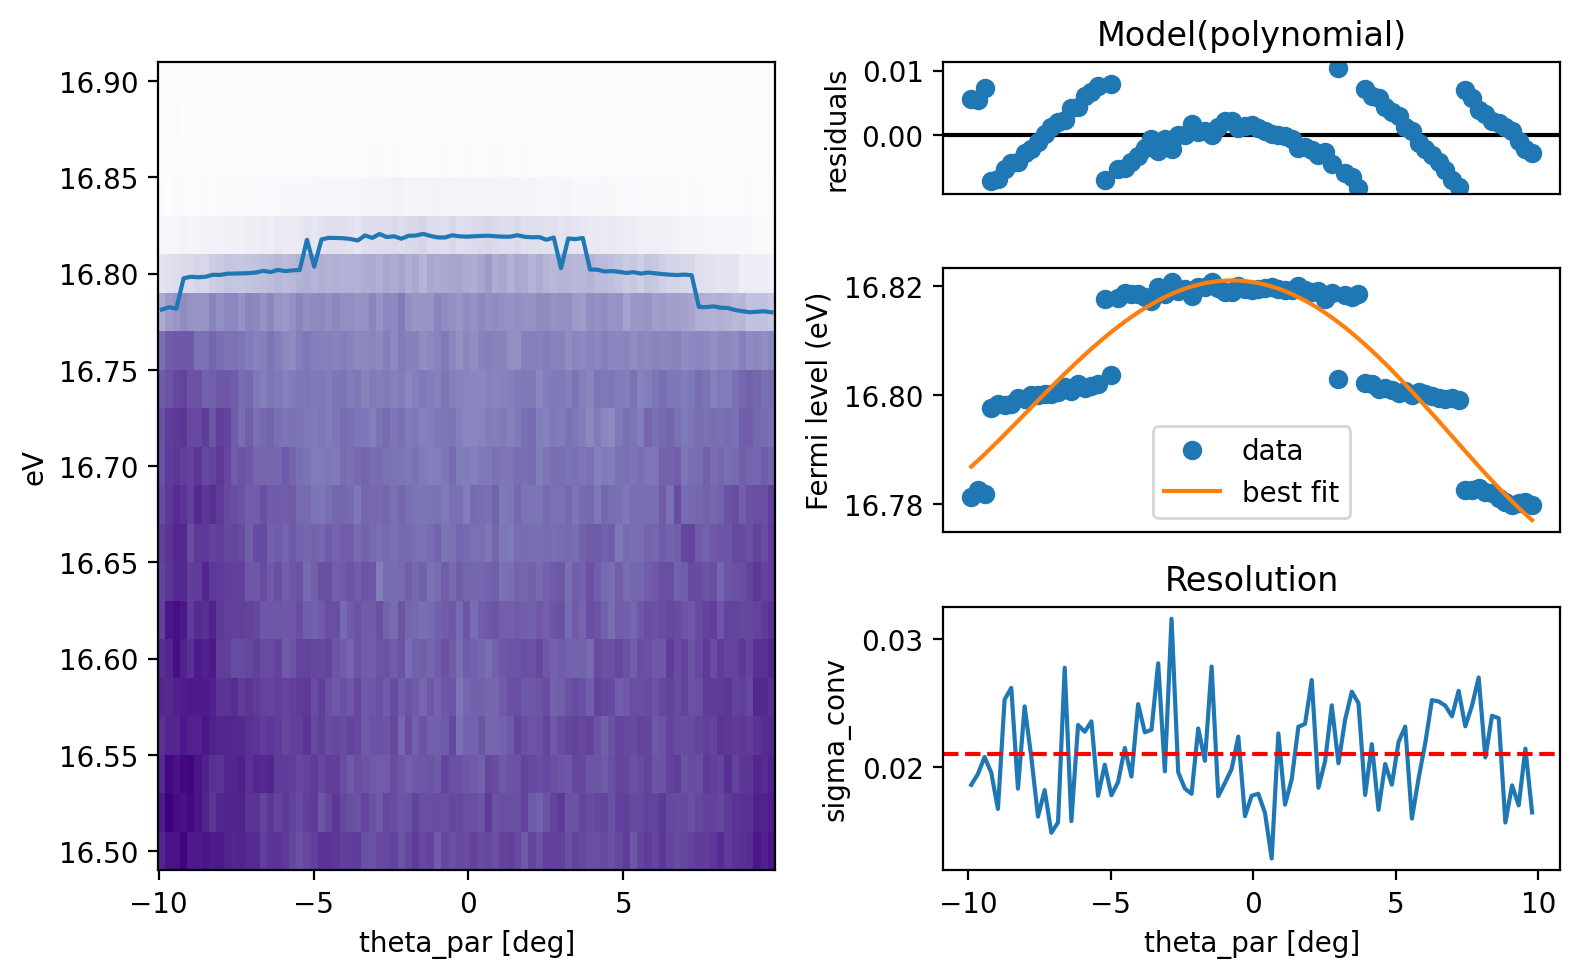

<div class="alert alert-block alert-success"><b>Au fitting results: </b> Polynomial Fermi level correction (order 4): c0: 16.820662, c1: -0.000854, c2: -0.000563, c3: 3e-06, c4: 2e-06;   Average resolution: 0.021 eV </div>

In [5]:
#Load relevant Au correction
gold = pks.load("Gold.xy").sel(eV=slice(16.5,None), theta_par=slice(-10,10)).coarsen(theta_par=4, boundary='trim').mean()
gold_fit_result = gold.fit_gold()

The resulting fit is stored as an attribute of the returned fit result:

In [6]:
gold_fit_result.EF_correction

{'c0': 16.820661910270843,
 'c1': -0.0008539311244898133,
 'c2': -0.0005631770683766936,
 'c3': 3.4029165887247228e-06,
 'c4': 1.6954533236374566e-06}

The $E_\mathrm{F}$ correction can be added to the attributes of any :class:`xarray.DataArray` using the `.set_EF_correction) method:

In [7]:
gold.set_EF_correction(gold_fit_result)

In [8]:
gold.attrs['EF_correction']

{'c0': 16.820661910270843,
 'c1': -0.0008539311244898133,
 'c2': -0.0005631770683766936,
 'c3': 3.4029165887247228e-06,
 'c4': 1.6954533236374566e-06}

### $k$-conversion
:class:`peaks` implements momentum conversion assuming the use of a hemispherical-type analyser with an entrance slice, with or without deflectors for virtual scanning of the angular axes, following the conventions of Ishida and Shin (https://aip.scitation.org/doi/10.1063/1.5007226). The conversion is exact (no small angle approximations are made). The following analyser types are currently supported:
- Type I: analyser slit aligned with main rotary axis of manipulator (`ana_slit_angle = 90`), often called 'vertical' slit for a vertically-oriented sample manipualator;
- Type II: analyser slit perpendicular to main rotary axis of manipulator (`ana_slit_angle = 0`), often called 'horizontal' slit.

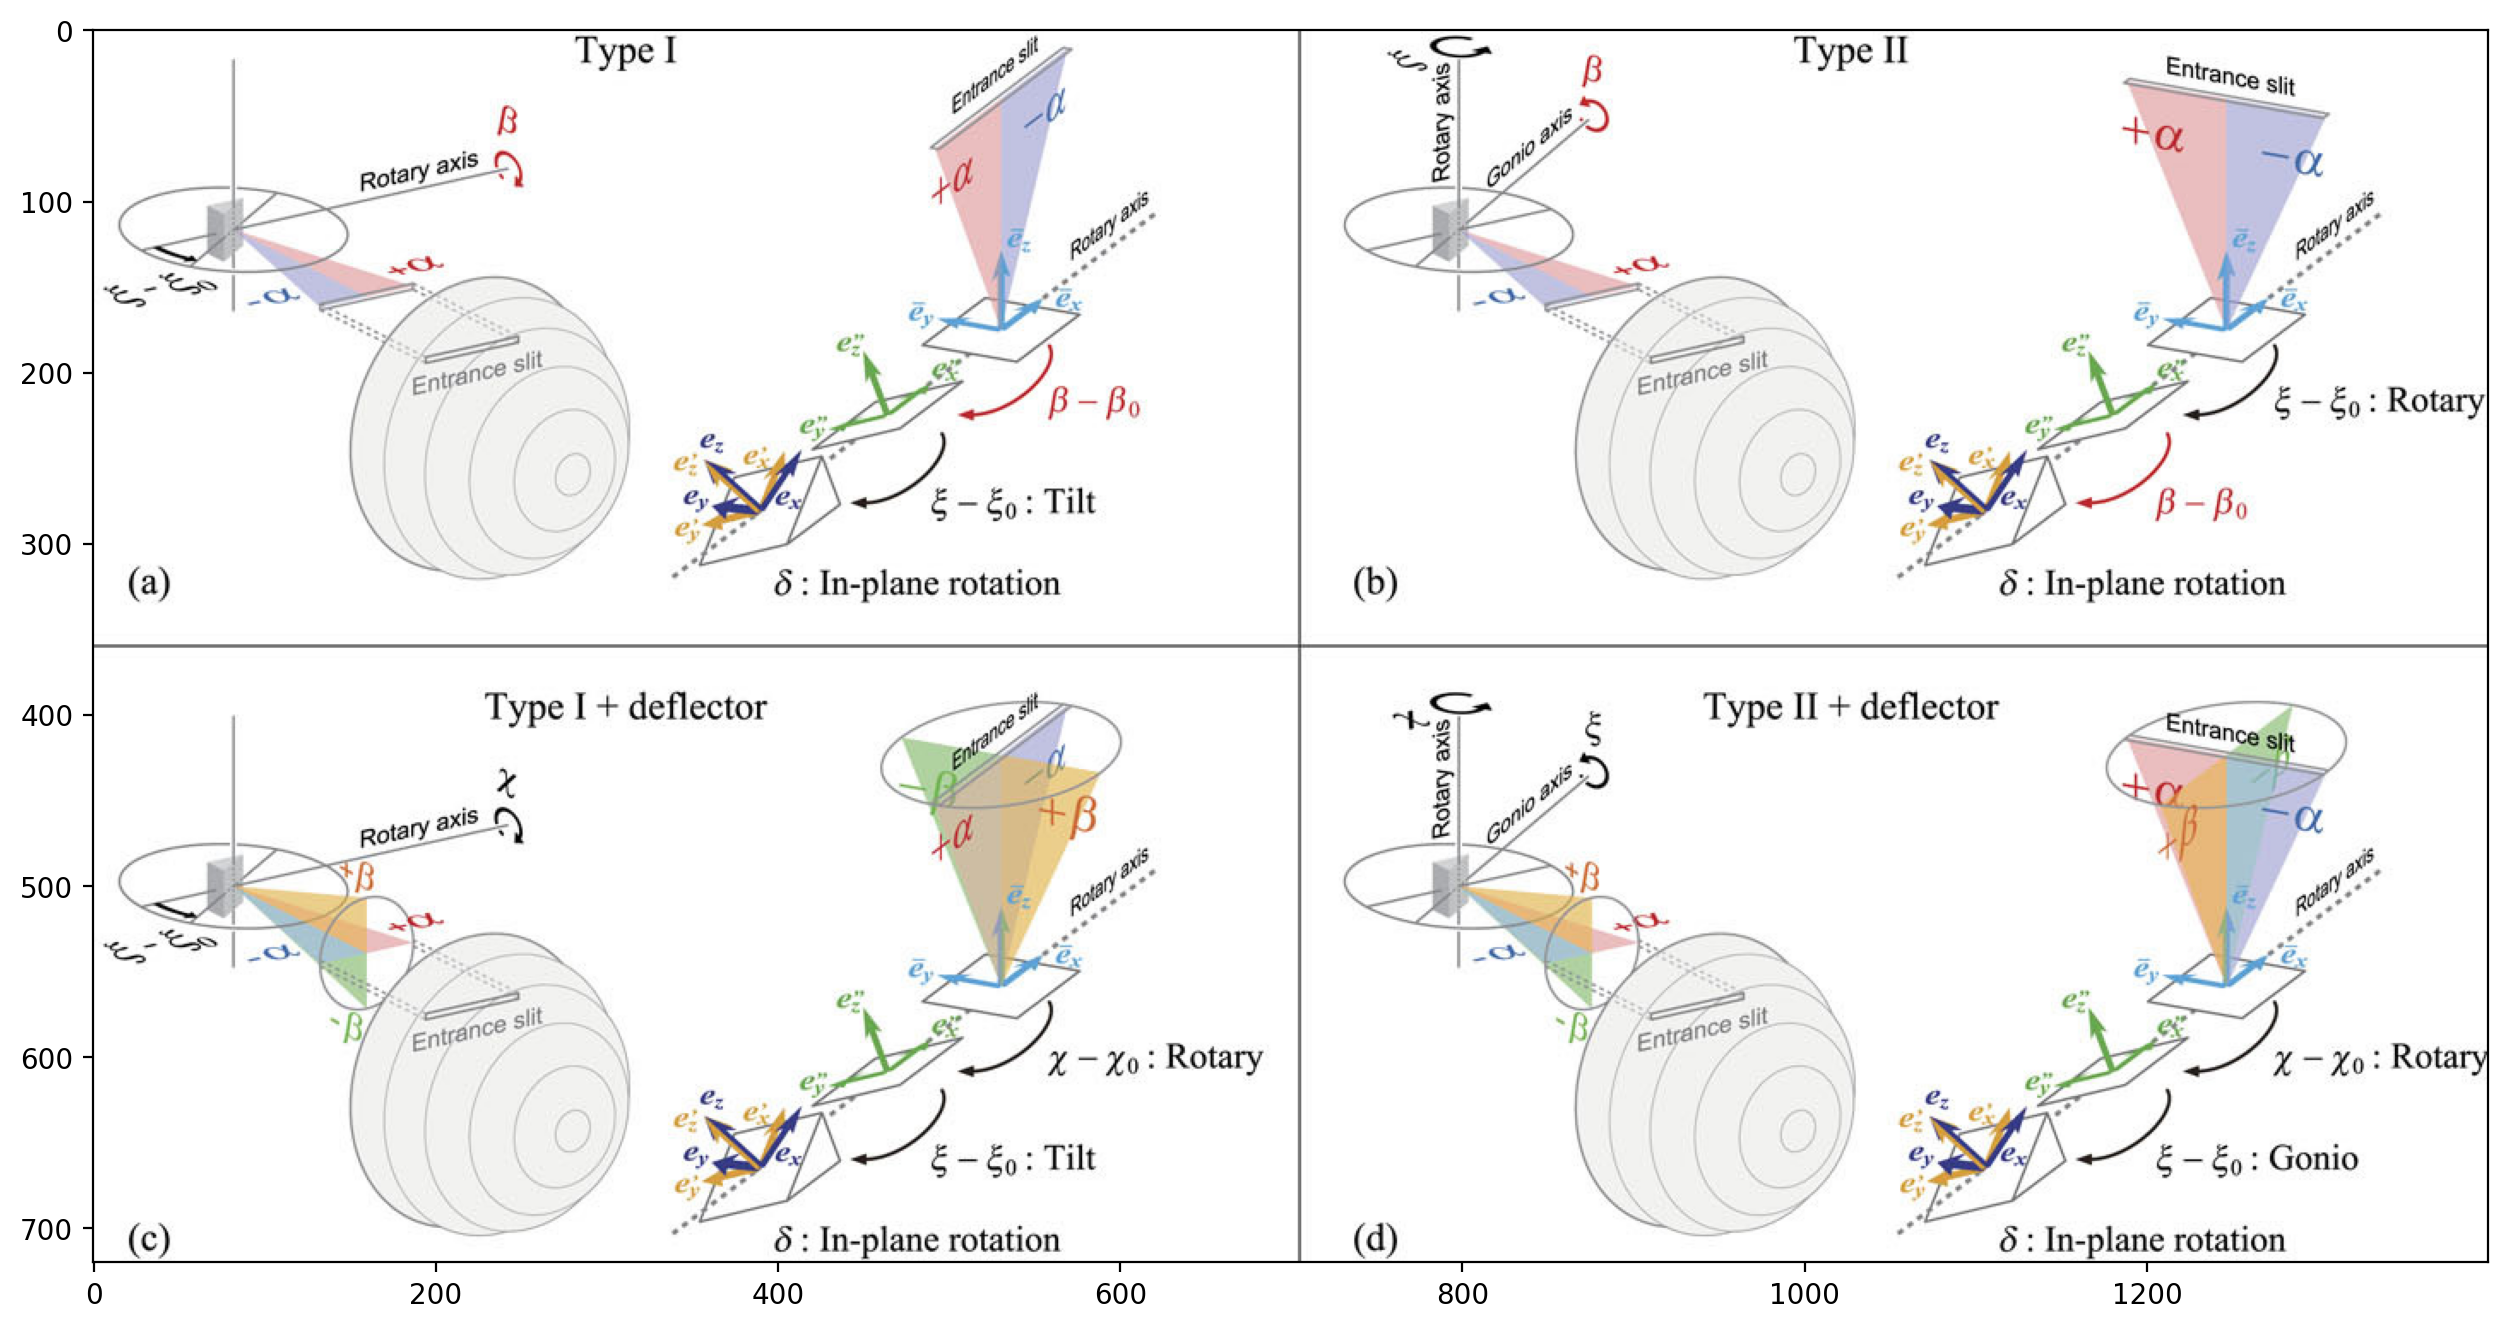

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(plt.imread("./k_conv_angle_conventions.jpeg"))

:::{note}
There are multiple conventions in particular regarding signs. We attempt to rigidly follow the above conventions, translating `peaks` angle conventions to match to the above. To aid in tracking sign changes in different systems, new file loaders should implement a new locaiton `Class` which subclasses `_BaseARPESConventions`, with sign conventions defined as required.

:::{danger}
Note, at present in the re-implementation of `peaks`, quite a lot changed under the hood in how we deal with this, and so there are many errors in tracking normal emissions and sign conventions for these things. Please take care when performing k-space conversions and also using the automated methods to feed back normal emission values - please report issues at https://gitlab.st-andrews.ac.uk/physics-and-astronomy/king-group/peaks/-/issues/3
:::
:::

### Dispersions
To process e.g. a dispersion: 

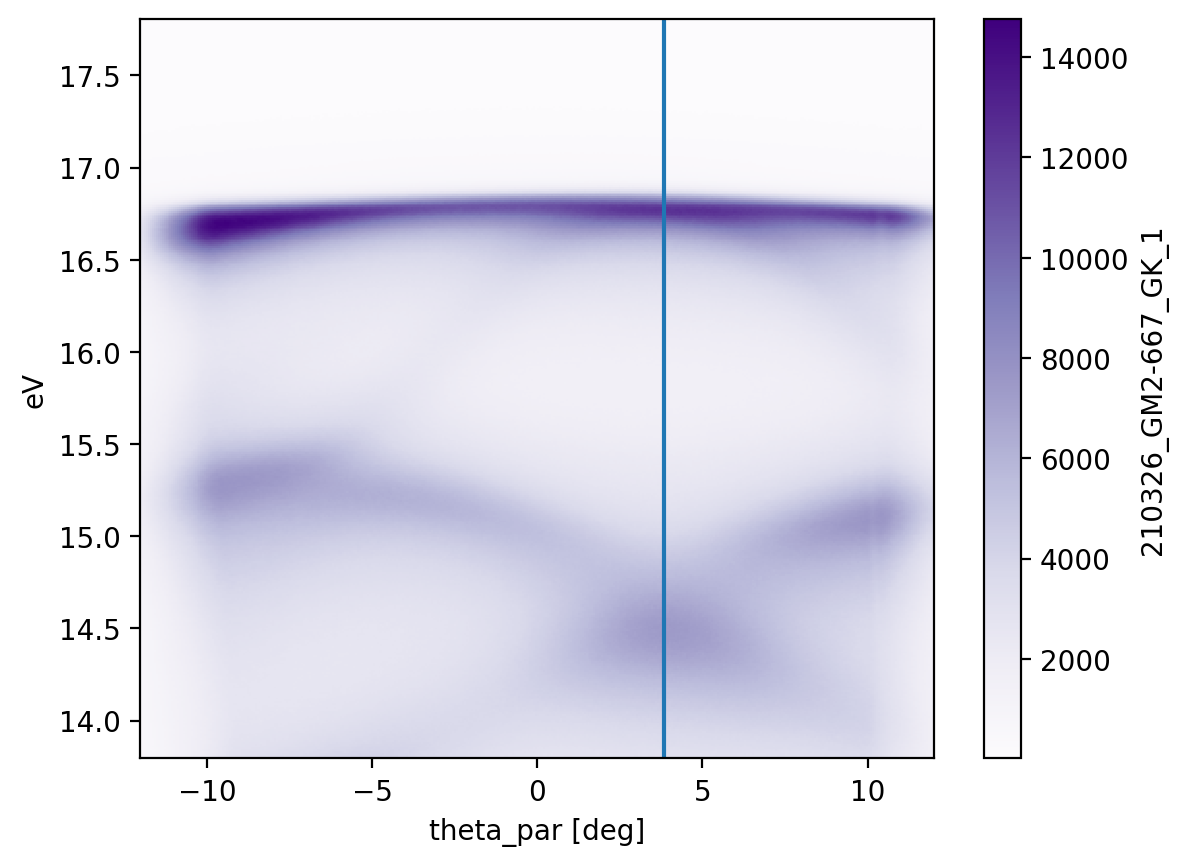

In [10]:
# Load a dispersion
disp1 = pks.load("210326_GM2-667_GK_1.xy")
disp1.plot()
plt.axvline(3.85)

# Manually set the norm_polar - we plan automated methods to aid this in future
disp1.attrs['norm_polar']=-3.85  

# Add the Fermi level reference from the fitted gold data
disp1.set_EF_correction(gold_fit_result)

In [11]:
disp1_k = disp1.k_convert()

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: polar: 0, tilt: 0, azi: 0, norm_tilt: 0, norm_azi: 0. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

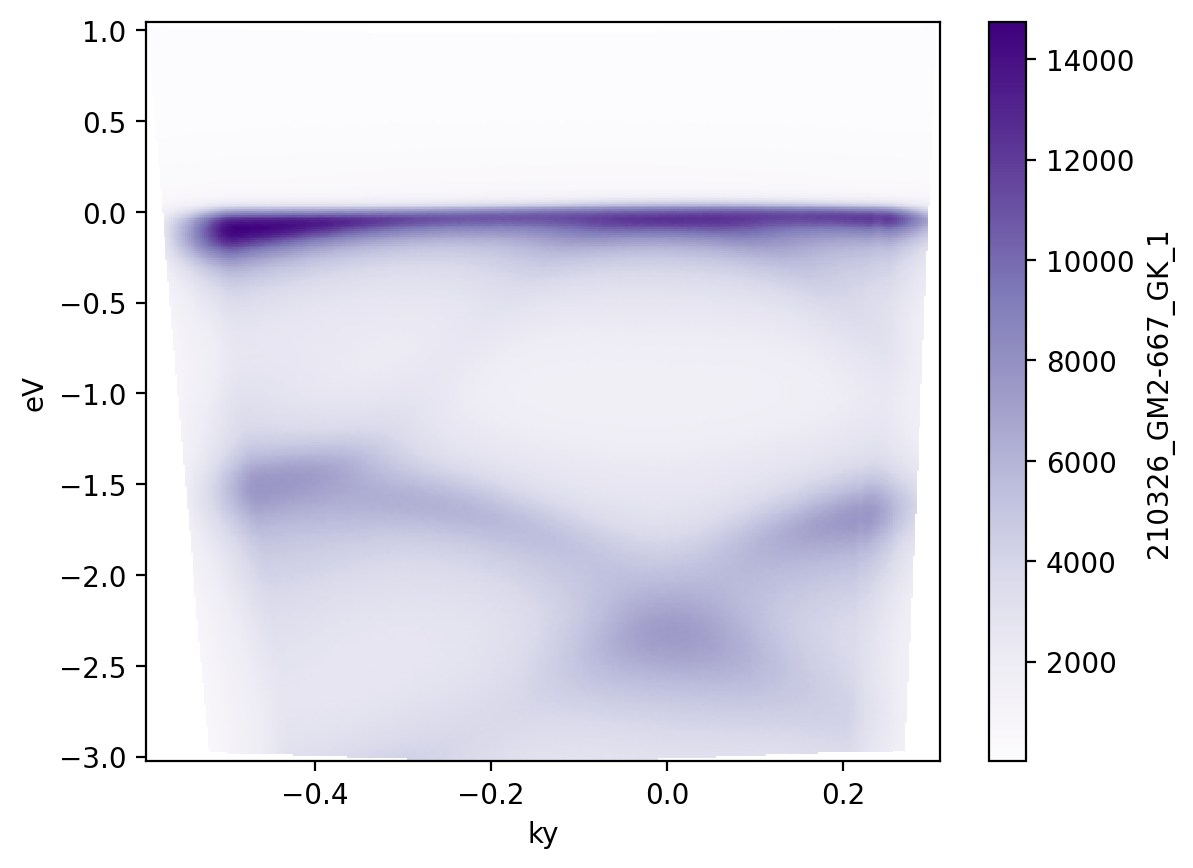

In [12]:
disp1_k.plot()

We can specify a desired k-point range and step size by providing the `ky` argument (note depending on the analyser, this could be `kx`) as a `slice(start, stop, step)`. Note, any of these can be retained at the default by passing `None` for that parameter:

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: polar: 0, tilt: 0, azi: 0, norm_tilt: 0, norm_azi: 0. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

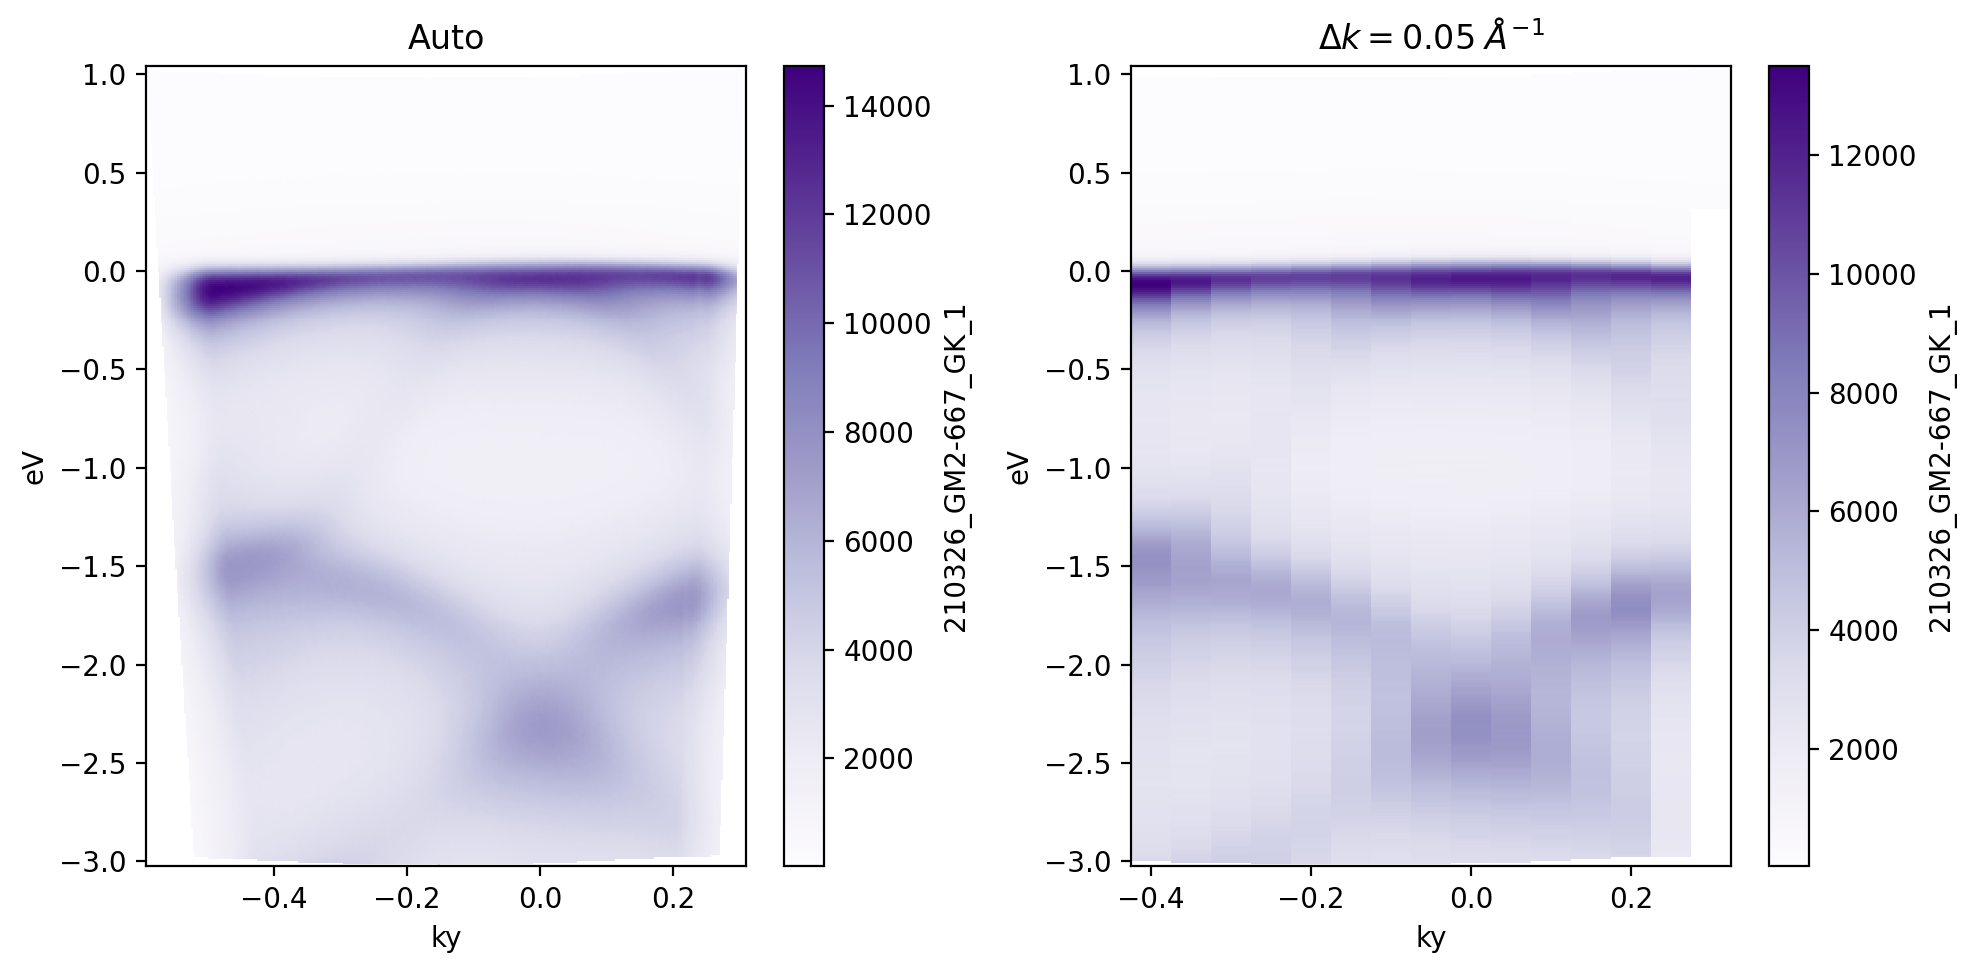

In [13]:
disp1_k2 = disp1.k_convert(ky=slice(-0.4,None,0.05))
pks.plot_grid([disp1_k, disp1_k2], titles=["Auto", "$\\Delta{}k=0.05\\;\\AA^{-1}$"])

:::{tip}
Specifying a reduced step size for the $k$ conversion only reduces the sampling density for the interpolation, it does not bin the data. If you are happy with a larger step size, it is better to first bin the data using e.g.:

```python
disp1.coarsen(theta_par=2).mean()
```
:::

Note that the methods attempt to estimate unspecified parameters if they are not set - note the `Analysis warning` boxes returned. E.g. if passing a freshly loaded dispersion without setting the `EF_correction` attribute, an automatic determination of the Fermi level will be attempted: 

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: polar: 0, tilt: 0, azi: 0, norm_tilt: 0, norm_azi: 0. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> EF_correction set from automatic estimation of Fermi level to: 16.82 eV.. NB may not be accurate. </div>

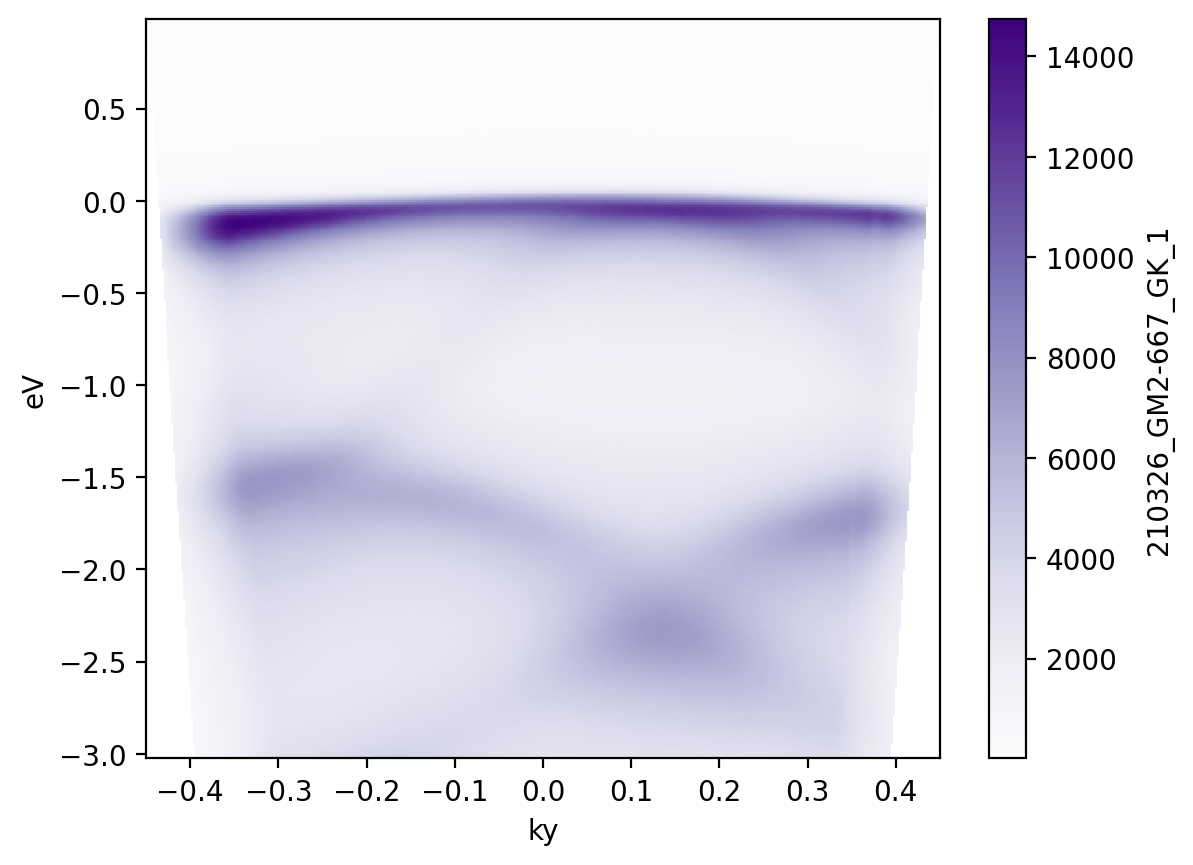

In [14]:
disp1_copy = pks.load("210326_GM2-667_GK_1.xy")
disp1_copy.k_convert().plot()

:::{warning}
These automatic estimations are useful for a quick look, but should not be relied upon for careful analysis!
:::

### Fermi surfaces
Fermi surface corrections work in the same way as for dispersions.

In [18]:
#Load a Fermi map and relevant Au correction
FS = pks.load('i05-59818.nxs', lazy=False)
gold = pks.load('i05-59853.nxs')
# Select a smaller range
gold = gold.sel(theta_par=slice(-16,17), eV=slice(104.9,105.2)).coarsen(theta_par=5,eV=2,boundary='trim').mean()

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract defl_perp metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract defl_perp metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

In [19]:
fit_result = pks.fit_gold(gold)
FS.set_EF_correction(fit_result)

Fitting:   0%|          | 0/137 [00:00<?, ?it/s]

<div class="alert alert-block alert-success"><b>Au fitting results: </b> Polynomial Fermi level correction (order 4): c0: 105.078501, c1: 0.000127, c2: -4.5e-05, c3: 1e-06, c4: -0.0;   Average resolution: 0.009 eV </div>

To return just a single slice in energy, the `eV_slice=(centre, width)` argument can be used, with the arguments specified in binding energy:

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: norm_polar: 0, norm_azi: -12.51. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

Interpolating onto new grid:   0%|                 | 0/25950000 [00:00<?, ?it/s]

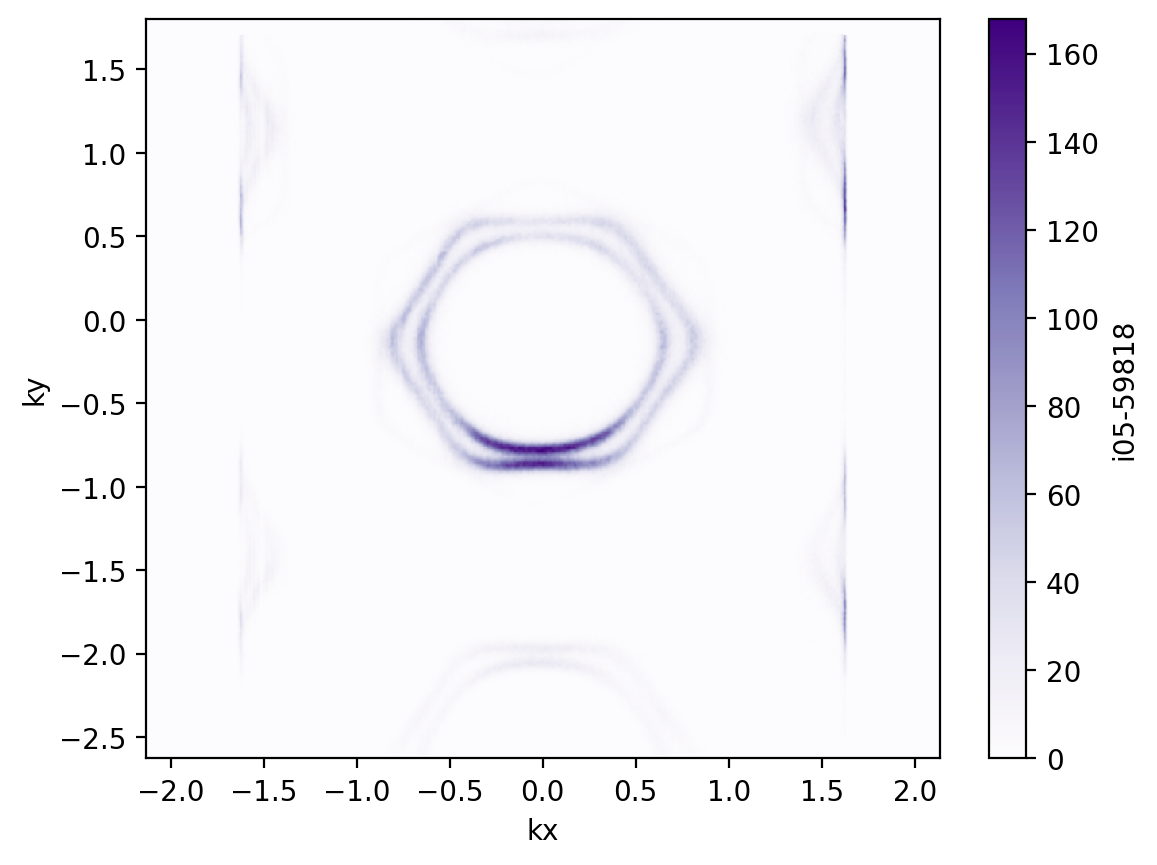

In [27]:
FSM_k = FS.k_convert(eV_slice=(-0.05,0.02))
FSM_k.plot()

Or the full cube can be $k$-converted

:::{tip}
`peaks` uses :class:`numba` and :class:`numexpr` to accelerate the interpolations and relevant angle <--> $k$ calculations, making the $k$-conversions rather fast. Still, for a large map these can still be somewhat time consuming, and it is often better perform binning on the data first.
:::

In [30]:
FS_bin = FS.coarsen(theta_par=2,eV=2,boundary='trim').mean()

In [32]:
FS_bin.attrs['norm_azi'] = -28
FS_bin_k = FS_bin.k_convert()

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: norm_polar: 0. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

Interpolating onto new grid:   0%|                | 0/140454000 [00:00<?, ?it/s]

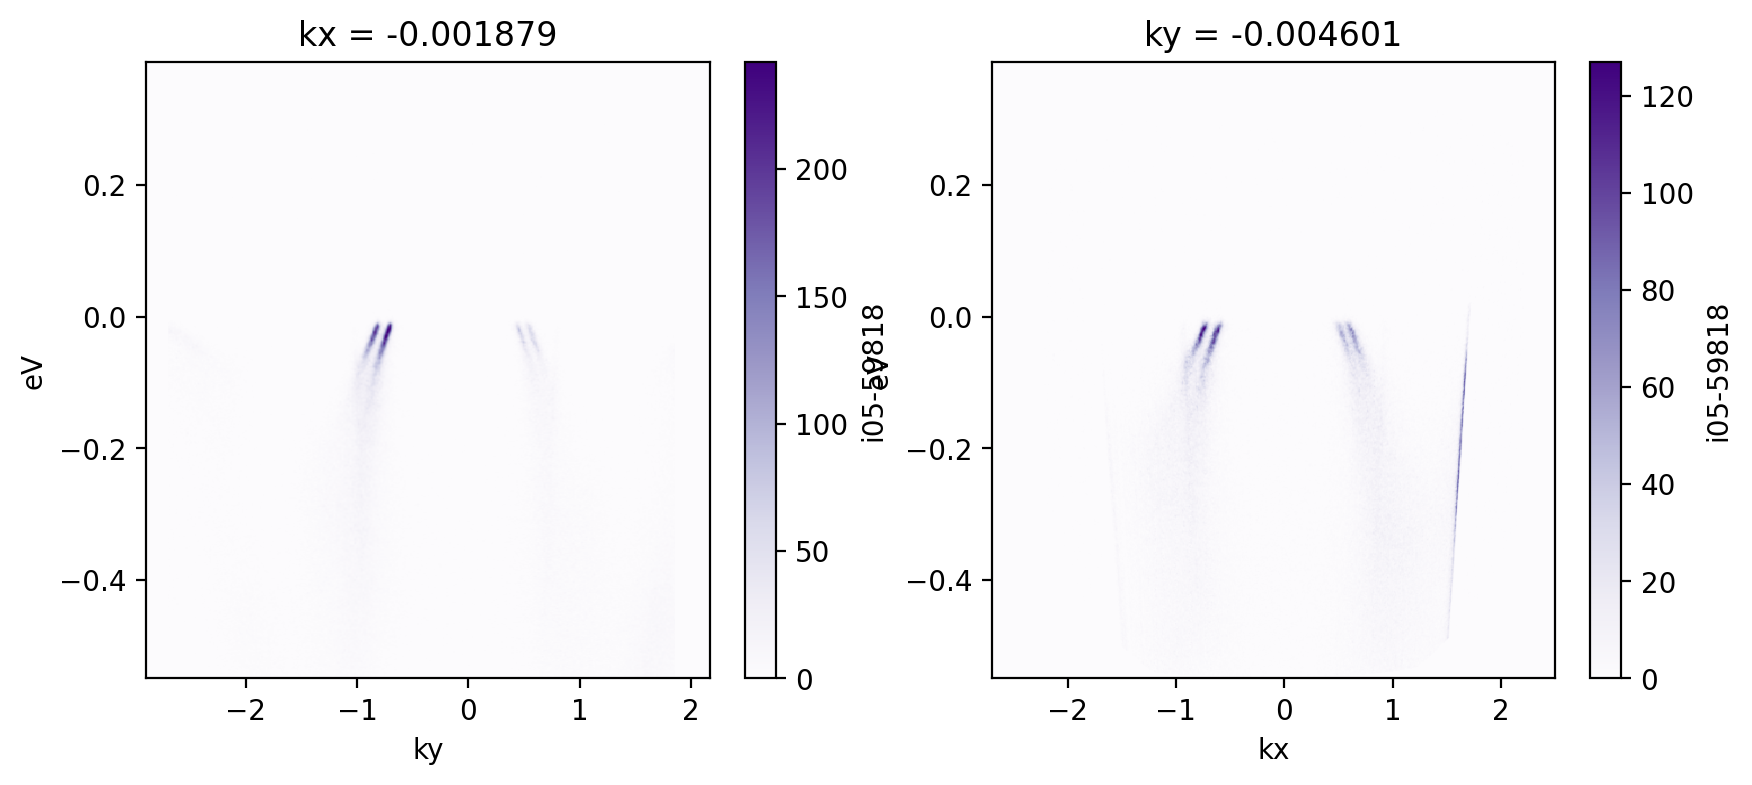

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
FS_bin_k.sel(kx=0,method='nearest').plot(y='eV', ax=axes[0])
FS_bin_k.sel(ky=0,method='nearest').plot(y='eV', ax=axes[1])

### Photon energy scans

#### Loading hv-dep data/data format
In an $h\nu$ scan, the most natural representation of the data is as a 3d cube of ($hv$,theta_par,eV), however the eV axis in raw kinetic energy changes as a function of photon energy, adding some extra complexity.

In :class:`peaks`, the convention is to load (or assemble) a $h\nu$-dependent dataset into such a cube, where the eV coordinate (when in kinetic energy mode) is that of the first scan, while a second non-dimension coordinate is included which shows the relevant offset of the KE scale as a function of hv. A warning on load indicates this. 

In [35]:
# Load data (kz map)
hv1 = pks.load('i05-69294.nxs')
hv1.attrs['norm_tilt'] = 6.05

<div class="alert alert-block alert-info"><b>Loading info: </b> The kinetic energy coordinates saved are that of the first scan. The corresponding offsets for successive scans are included in the KE_delta coordinate. Run DataArray.disp_from_hv(hv), where DataArray is the loaded hv scan xarray.DataArray and hv is the relevant photon energy, to extract a dispersion at using the proper kinetic energy scaling for that photon energy. </div>

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract sweeps metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract defl_perp metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

:::{note}
Due to this perculiar data structure, if a single scan is selected using the usual `.sel(hv=...)` method, the incorrect energy scale will be returned. We have a helper method, `disp_from_hv` to overcome this problem
:::

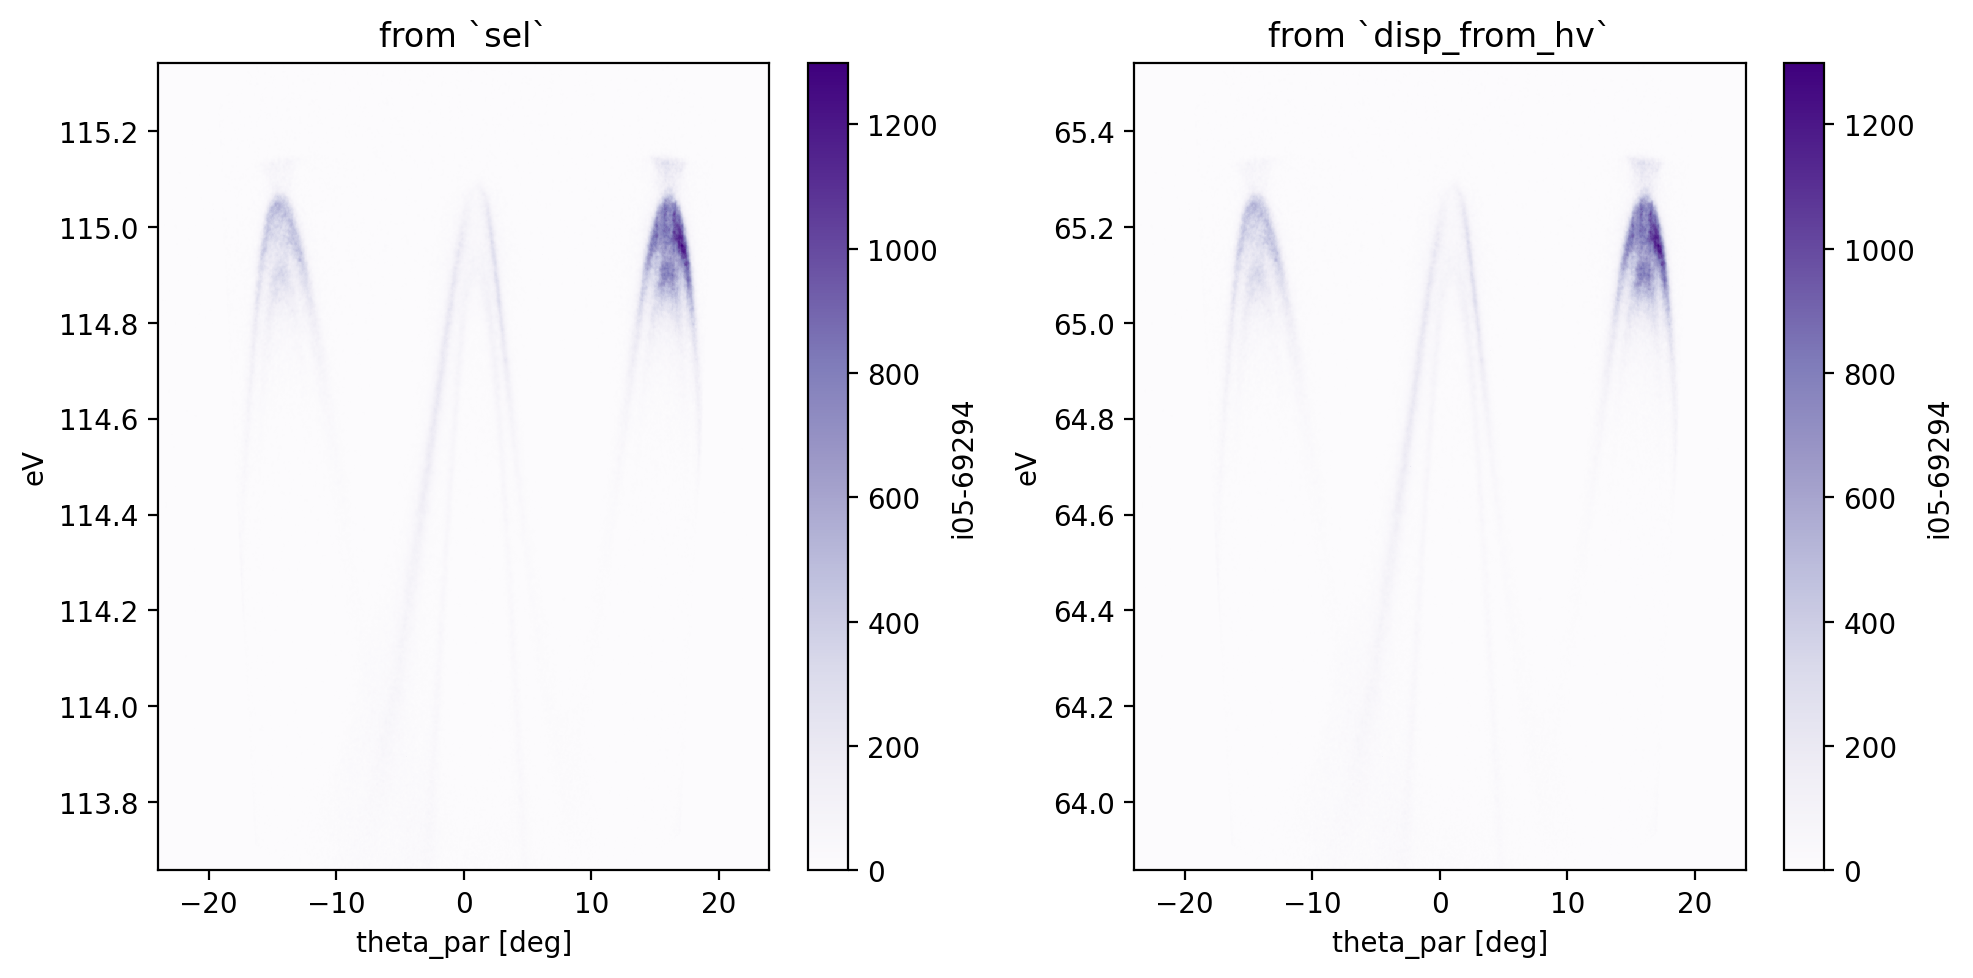

In [22]:
pks.plot_grid([hv1.sel(hv=70),hv1.disp_from_hv(70)], titles=['from `sel`', 'from `disp_from_hv`'])

Note the incorrect energy scale on the left!

#### $k$-conversion

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract sweeps metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

<div class="alert alert-block alert-danger"><b>Loading info: </b> Unable to extract defl_perp metadata. If you expected this to be in the available metadata, update the metadata loader in peaks.core.fileIO.loaders to account for new file format. </div>

Fitting:   0%|          | 0/626 [00:00<?, ?it/s]

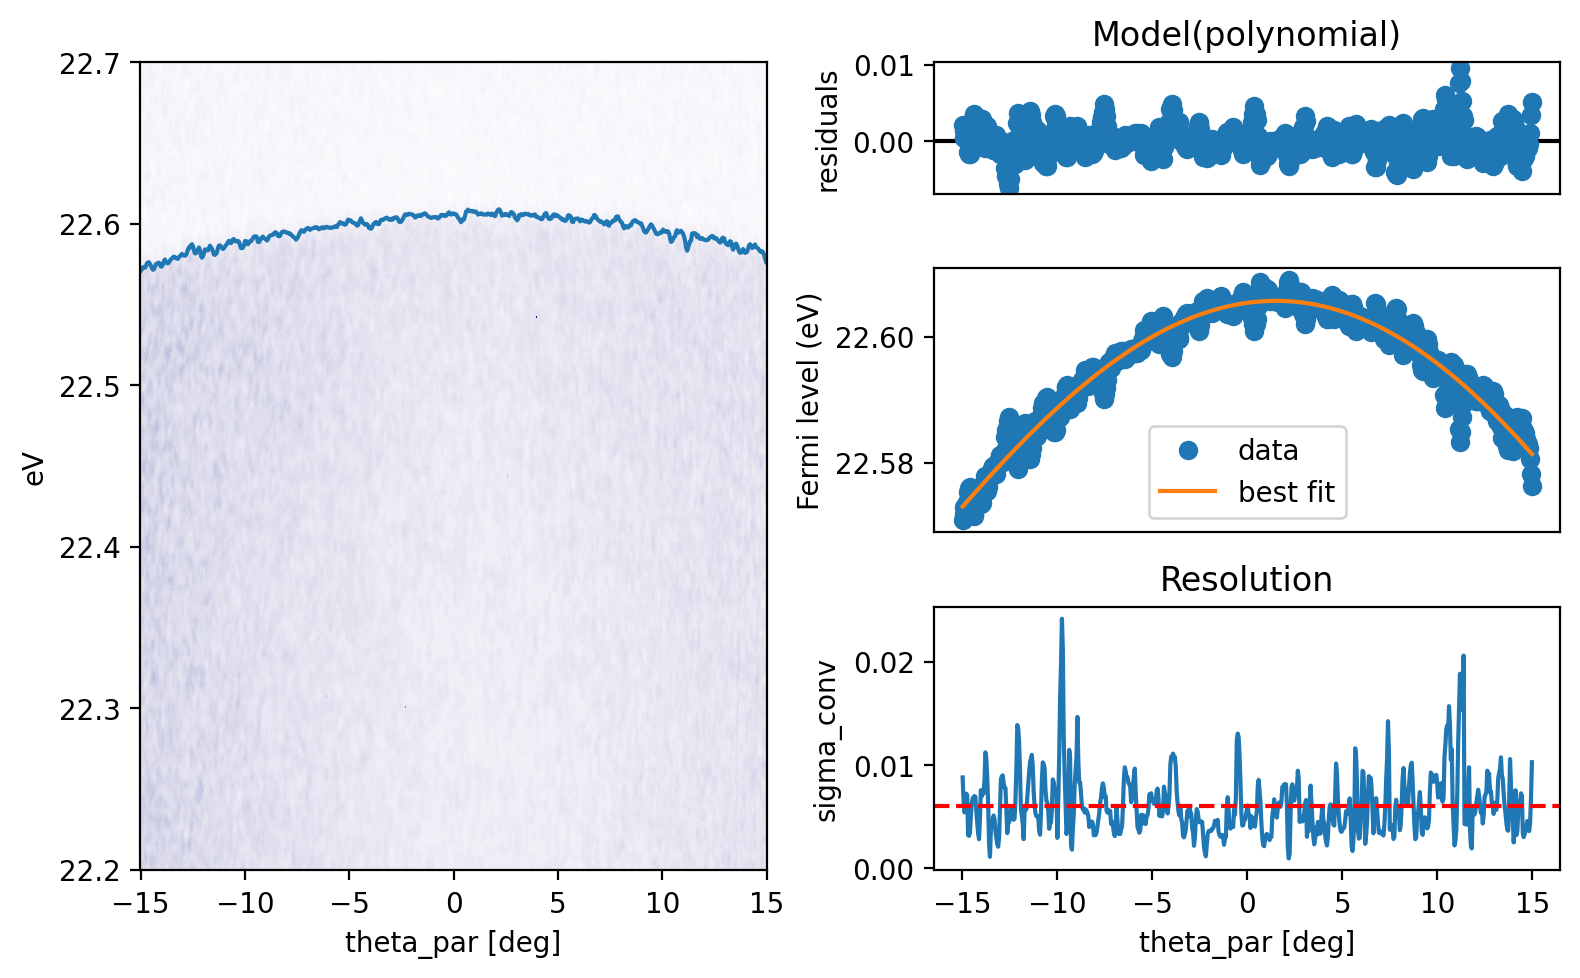

<div class="alert alert-block alert-success"><b>Au fitting results: </b> Polynomial Fermi level correction (order 4): c0: 22.605368, c1: 0.000414, c2: -0.000136, c3: -1e-06, c4: 0.0;   Average resolution: 0.006 eV </div>

In [23]:
# Load a gold reference scan for a single energy
gold = pks.load('i05-70214.nxs').sel(theta_par=slice(-15,15),eV=slice(22.2,22.7))
fit_result = gold.fit_gold()

This gives the angle-dependent correction, but an $h\nu$-dependent correction will also be required. This can be added as a new co-ordinate:

```python
data = data.coords.update({"EF": ("hv", estimated_EF)})
```
where estimated_EF is a :class:`numpy.ndarray` of length equal to the number of photon energies. Or it can be automatically estimated from `.estimate_EF()` which is run automatically if the `.k_convert` function is run with no Fermi correction already set.

In [36]:
# Adding the angle-dep part
hv1.set_EF_correction(fit_result)

# Set the inner potential via the attributes
hv1.attrs["V0"] = 15

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: norm_polar: 0.0, norm_azi: 19.98. </div>

Converting data to k-space - initialising:   0%|          | 0/4 [00:00<?, ?it/s]

<div class="alert alert-block alert-info"><b>Analysis info: </b> Estimated Fermi level correction across the photon energy range via an order 3 polynomial fit as {'c0': '0.10445', 'c1': '0.83202', 'c2': '0.00200', 'c3': '-0.00001'} </div>

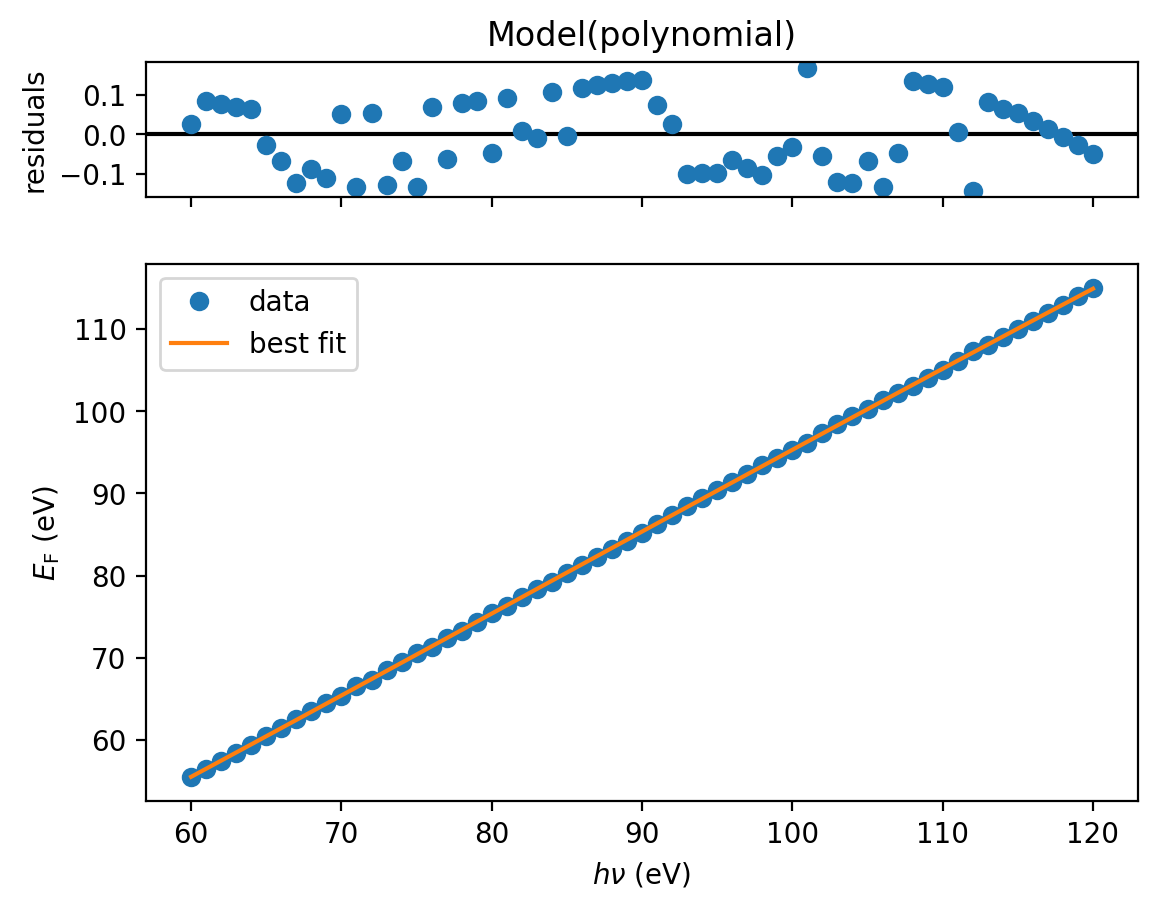

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> EF_correction set from automatic estimation of Fermi level to: 55.49-114.91 eV (hv dependent). NB may not be accurate. </div>

Interpolating onto kz grid:   0%|                 | 0/160084000 [00:00<?, ?it/s]

In [37]:
# Now do the k-conversion and the rest is estimated
hv1_k = hv1.k_convert()

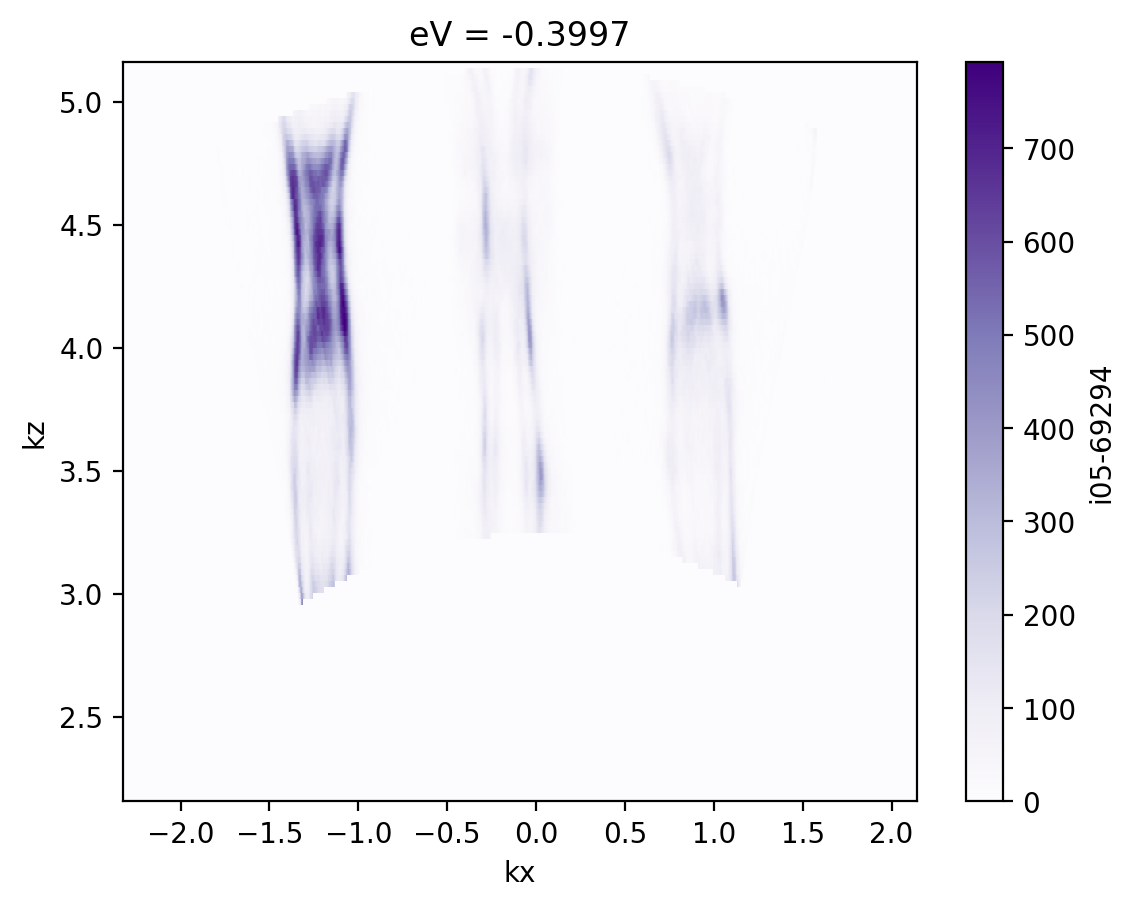

In [38]:
# Plot a slice from the k-converted data cube 
hv1_k.MDC(-0.40, 0.02).plot()

The other arguments for selecting the $k$ and $E$ range returned work as before, while an additional argument allows for the data to be returned in photon energy instead of $k_z$:

<div class="alert alert-block alert-warning"><b>Analysis warning: </b> Some manipulator data and/or normal emission data was missing or could not be passed. Assuming default values of: norm_polar: 0.0, norm_azi: 19.98. </div>

Converting data to k-space - initialising:   0%|          | 0/3 [00:00<?, ?it/s]

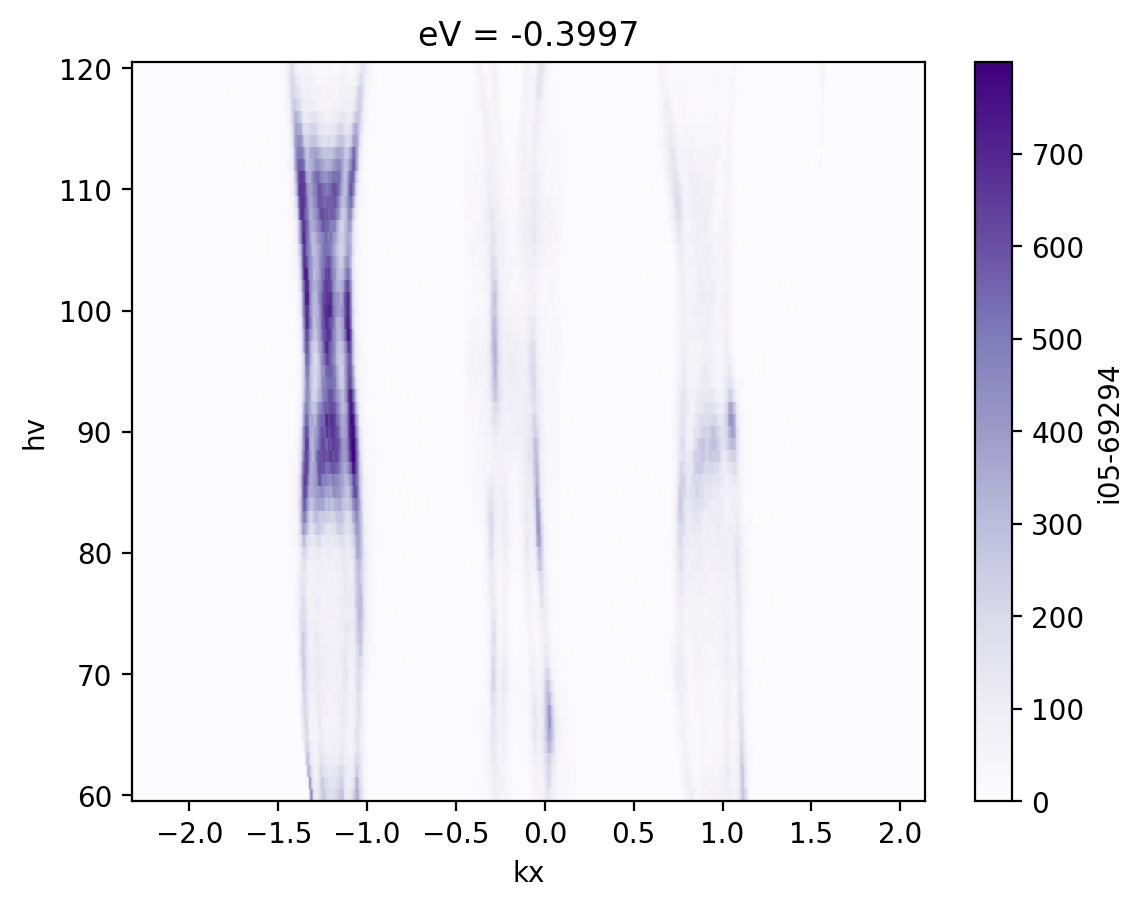

In [39]:
hv1_kip = hv1.k_convert(return_kz_scan_in_hv=True)
hv1_kip.MDC(-0.40, 0.02).plot()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='merge'></a>
## Merging
We can also merge dispersions passed as a list to proc, by calling with the flag `merge=True`. If merging there are two further useful arguments:
 - `flip=True/False` is used to set whether to 'flip' the manipulator axis sign when merging multiple scans onto an enhanced theta_par range. Whether to do this depends on the sign conversion between `theta_par` and the relevant manipulator angle (`polar` or `tilt` depending on Type I or II configuration). This defaults to False, which is correct e.g. for the StA Phibos.
 - `theta_par = slice(th0,th1)` can be used to crop the data to the specified theta_par range before merging the scans together. This is often required in merging as the edges of the detector may be visible, or the scan may show distortions/unphysical intensity variations towards the edges of the detector that need to be cut off to not lead to weird features in the middle of the merged image. 

In [18]:
#Load data again
file = "example_data/Gold.xy" #StA ARPES Disp.
gold = load_data(file)
file = "example_data/210326_GM2-667_GK_1.xy" #StA ARPES Disp.
GK_1 = load_data(file)
file = "example_data/210326_GM2-667_GK_2.xy" #StA ARPES Disp.
GK_2 = load_data(file)
file = "example_data/210326_GM2-667_GK_3.xy" #StA ARPES Disp.
GK_3 = load_data(file)

In [139]:
b = proc([GK_1,GK_2,GK_3], polar=[0,12,24], norm_polar = 4, EF_correction=correction, merge=True, theta_par=slice(-10,10))

Converting to binding energy:
210326_GM2-667_GK_1
210326_GM2-667_GK_2
210326_GM2-667_GK_3
Data cropped to theta_par range : (-10, 10)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


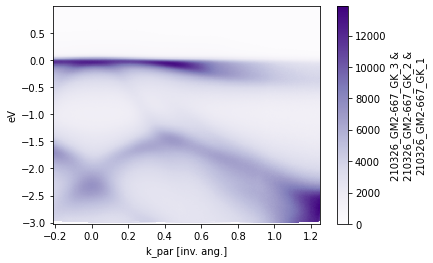

In [140]:
b.plot()

As an example of running with `flip=True`, returns wrong results here, but should be applied in some other cases. 

Converting to binding energy:
210326_GM2-667_GK_1
210326_GM2-667_GK_2
210326_GM2-667_GK_3
Data cropped to theta_par range : (-10, 10)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


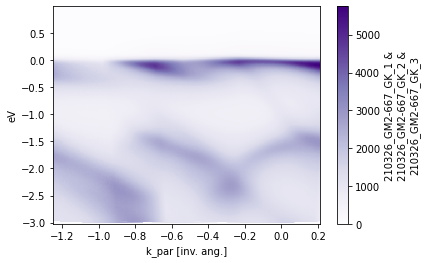

In [142]:
b = proc([GK_1,GK_2,GK_3], polar=[0,12,24], norm_polar = -4, EF_correction=correction, merge=True, flip=True, theta_par=slice(-10,10))
b.plot()

Merging also works for higher-dimensional data.

In [19]:
# Load two Diamond FS maps to join up
file = "example_data/i05-34239.nxs"
map1a = load_data(file)  # Patial range of map 1
file = "example_data/i05-34237.nxs"
map1b = load_data(file)  # Partial range of map 2
file = "example_data/i05-34242.nxs"
map2 = load_data(file)

Persisting data to memory:   0%|          | 0/1 [00:00<?, ?it/s]

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

Persisting data to memory:   0%|          | 0/10 [00:00<?, ?it/s]

In [146]:
# First need to stitch map1a and map1b together, as these are just partial ranges of one slice in this particular example dataset
map1 = xr.concat([map1a,map1b], dim="polar")

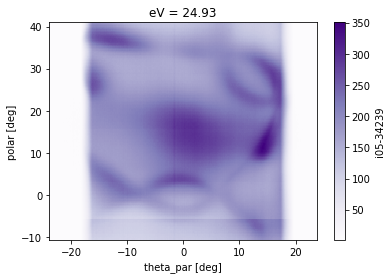

In [147]:
map1.FS(0.01, 25.62).plot()

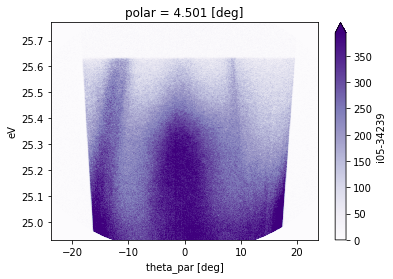

In [149]:
map1.isel(polar=45).plot(robust=True)

Note, these can be slow to convert if calling the full slice, automatic binning is applied if the first dataarray size $>10^8$ points.

In [150]:
b = proc([map1,map2], merge=True, theta_par=slice(-14,14), eV=slice(-0.1,0), flip=True)

 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/peaks/process/process.py:149: UserWarning:Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


Converting to binding energy:
i05-34239


 Analysis warning: Fermi level set from automatic estimation to 25.632 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.


i05-34242


 Analysis warning: Fermi level set from automatic estimation to 25.632 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.


Data cropped to theta_par range : (-14, 14)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': -7.0}


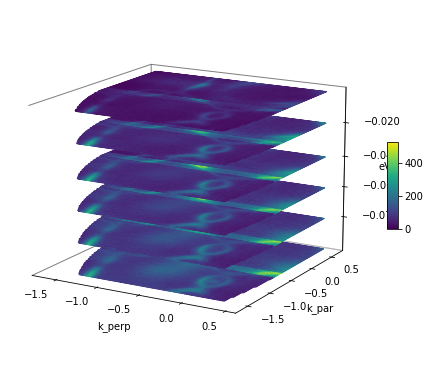

In [151]:
b.FS_stack(-0.1,0,0.025, 0.02, plot=1, cmap='viridis', figsize=(8,8), elev=15)

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='norm'></a>
## Normalisation
Normalise data by a float, EDC/MDC, or region of interest using `.process.norm.norm()`  This is loaded automatically as part of a * import of PyPhoto, and can be called either as `norm(data, *args, **kwargs)` or using the pipe function of xarray, `data.norm(*args, **kwargs)`. Multiple arguments are accepted:

In [152]:
help(norm)

Help on function norm in module peaks.process.norm:

norm(dispersion, *args, **kwargs)
    This function applies a simple normalisation by e.g. an MDC, EDC, or ROI
    
    Input:
        dispersion - the dispersion to be normalised (xarray). If supplied with no further arguments,
          then normalisation to the max value is performed (i.e. spectrum normalised to unity).
          Otherwise specify via:
        *args - optional arguments to normalise by a constant and/or the mean across a complete dimension. E.g.:
            int or float - normalise by that number
            'eV' - normalise by an integrated MDC
            'theta_par' or 'k_par' or 'k_perp' - normalise by an integrated EDC in that direction
            'all' - normalise by mean of the xarray
        **kwargs - optional arguments to define the slice to normalise by. E.g.:
            eV=slice(105,105.1)) -- normalized by an integrated MDC defined by the eV slice given, automatically
              broadcast over a

### Example on a dispersion

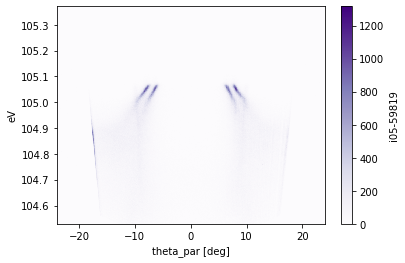

In [154]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

### Normalising by max value

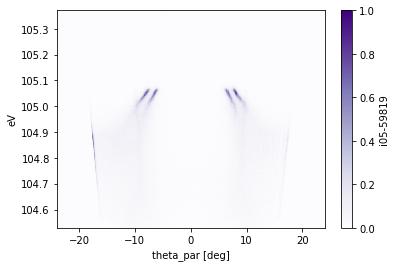

In [155]:
a.norm().plot(y='eV')

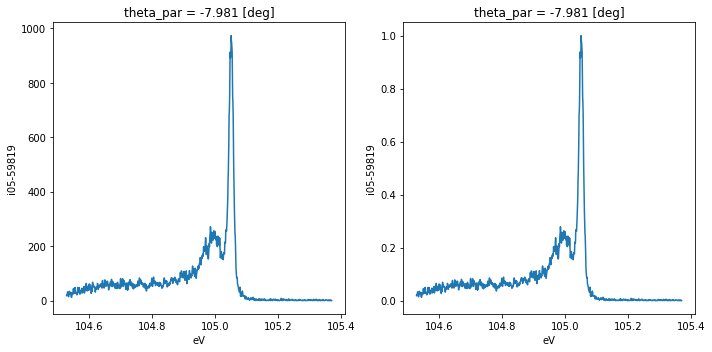

In [156]:
plot_grid([a.EDC(-8),a.EDC(-8).norm()])

### Normalising by a single number

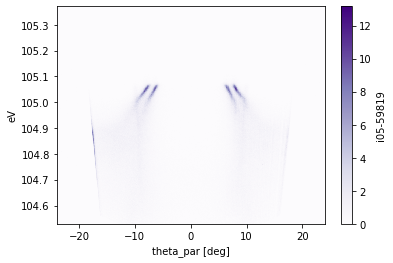

In [157]:
#normalise entire array by 100
a.norm(100).plot(y='eV')

We can normlise by the mean of the array with the shortcut 'all'

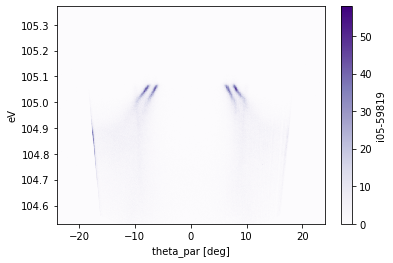

In [158]:
a.norm('all').plot(y='eV')

In [159]:
#The above has normalised by mean of dataarray:
a.mean().values

array(22.74448, dtype=float32)

We can normalise by these both, or in fact any number or combination

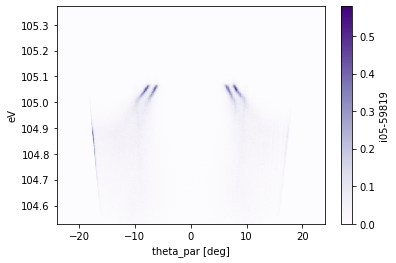

In [160]:
a.norm(10,10,'all').plot(y='eV')

### Normalising by an EDC or MDC
There is a shortcut to divide by an integrated MDC or EDC across the entire array, by calling the coordinate name as a string.

E.g. the integrated EDC of this array:

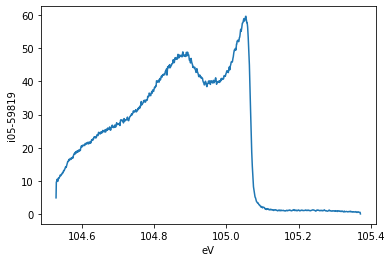

In [161]:
a.mean('theta_par').plot()

Normalising our 2D array by the above integrated EDC will divide each MDC by the equivalent value at that energy in this EDC, or the equivalent for the integrated MDC

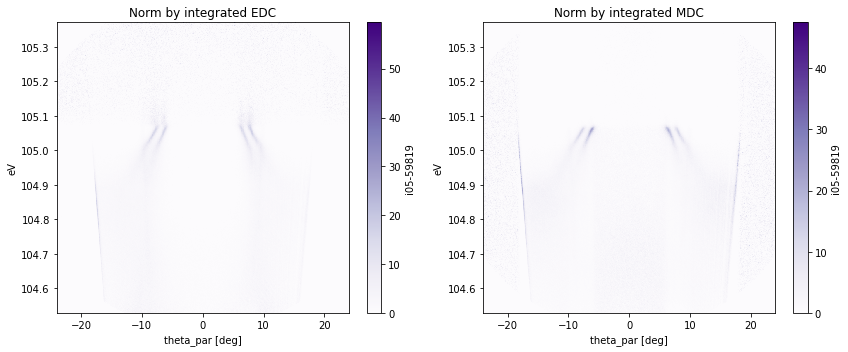

In [162]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
a.norm('theta_par').plot(y='eV', ax=axes[0])
axes[0].set_title('Norm by integrated EDC')
a.norm('eV').plot(y='eV', ax=axes[1])
axes[1].set_title('Norm by integrated MDC')
plt.tight_layout()

We can also integrate over a relevant DC defined over some integration region by calling with a slice command

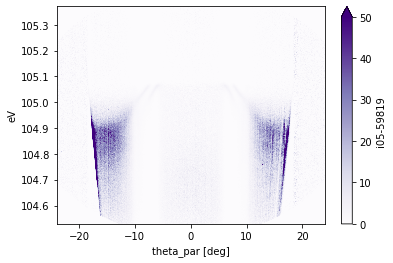

In [163]:
a.norm(eV=slice(105,105.1)).plot(y='eV', vmax=50)

### Region of interest

If we call e.g. both an EDC and MDC region to normalise a 2D array, this defines a region of interest, and we normalise by the mean value within that ROI 

In [164]:
#Mean of the following ROI
a.sel(eV=slice(104.9,105),theta_par=slice(-15,-10)).mean().values

array(77.7265, dtype=float32)

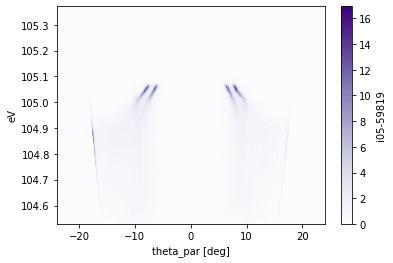

In [165]:
#Normalise by this ROI mean
a.norm(eV=slice(104.9,105),theta_par=slice(-15,-10)).plot(y='eV')

We can mix integrated and defined regions, and can combine with normalisation by a single number. 

NB the order of args (numbers and strings) and kwargs (labelled slices) matters here.

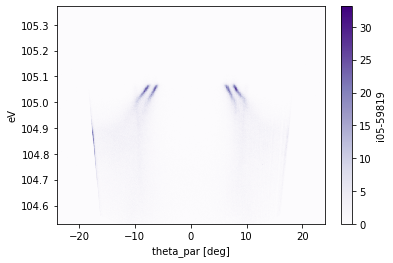

In [166]:
a.norm('eV', theta_par=slice(-15,-10)).plot(y='eV')

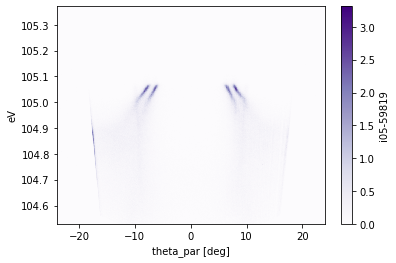

In [167]:
a.norm(10, 'eV', theta_par=slice(-15,-10)).plot(y='eV')

If we take a 1D array, then a single slice along that region corresponds to an effective ROI

E.g. for an EDC

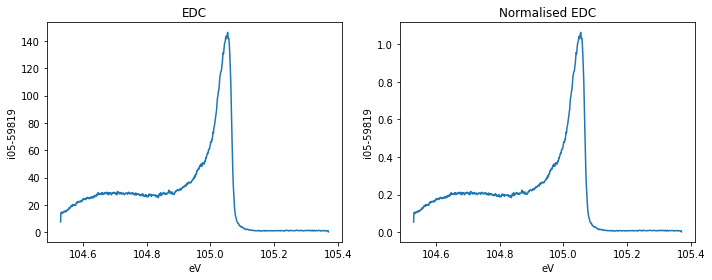

In [168]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
b = a.sel(theta_par=slice(-9.5,9)).mean('theta_par')
b.plot(ax=axes[0])
axes[0].set_title('EDC')
b.norm(eV=slice(105.04,105.05)).plot(ax=axes[1])
axes[1].set_title('Normalised EDC')
plt.tight_layout()

This should all broadcast OK for higher-dimension arrays as well, although that is not tested much yet. 

### Normalisation using user-defined wave
We can feed directly the normalisation wave as an xarray with the values and a co-ordinate which matches that of the data to be normalised.

E.g. normalising by an EDC manually extracted from the original data:

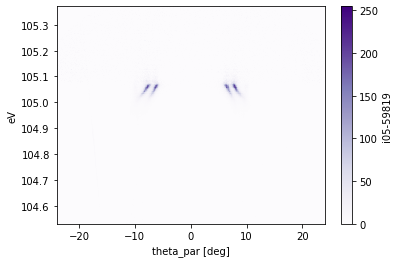

In [169]:
#Define the normalisation wave
norm_wave = a.sel(theta_par=slice(-15,-10)).mean('theta_par')
norm_wave
a.norm(norm_wave).plot(y='eV')

We can also call this with a normalisation wave defined on the same axis range using an xarray, but which does not match all co-ordinate values, or even cover the same range. E.g. let's define a linear background.

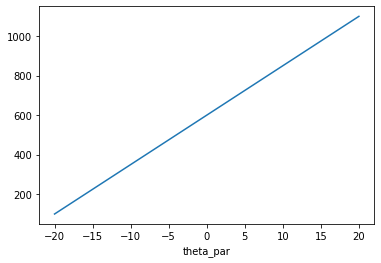

In [170]:
#Make a dummy background wave
data = np.arange(11)*100+100
theta_par = (np.arange(11)*4)-20

bgw = xr.DataArray(data, coords=[theta_par], dims=["theta_par"])
bgw.plot()

Use this to normalise - it will be extrapolated over the full range and interpolated to match the data points. We will get a warning that interpolation was utilised, but it will still run. 

 Analysis warning: Coordinates of normalisation wave do not match those in data. Interpolating for normalisation.


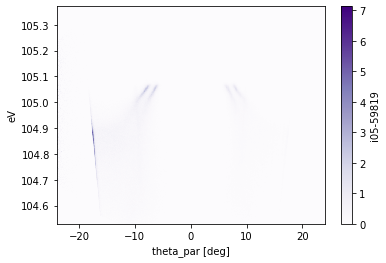

In [171]:
a.norm(bgw).plot(y='eV')

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='bgs'></a>
## Background subtraction

Background subtraction works in exactly the same way, except calling bgs, and the relevant parameters passed definie the wave to subtract. 

In [172]:
help(bgs)

Help on function bgs in module peaks.process.norm:

bgs(dispersion, *args, **kwargs)
    This function applies a simple background subtraction by e.g. an MDC, EDC, or ROI. It works just by calling
    the norm function with a flag to indicate background subtraction
    
    Input:
    
        `dispersion` - the dispersion to be normalised (xarray)
    
        `*args` - optional arguments to normalise by a constant and/or the mean across a complete dimension. E.g.:
    
            - `int` or `float` - subtract that number
    
            - ``eV'` - subtract an integrated MDC
    
            - `'theta_par'` or `'k_par'` or `'k_perp'` - subtract an integrated EDC in that direction
    
            - `'Shirley'` - subtract a shirley background, assuming default parameters unless `shirley_options`
                also passed. NB if Shirley passed, all other arguments ignored and only a Shirley bgs performed
    
            - `'all'` - subtract the mean of the xarray
    
        `**kw

For example, background subtraction of an MDC:

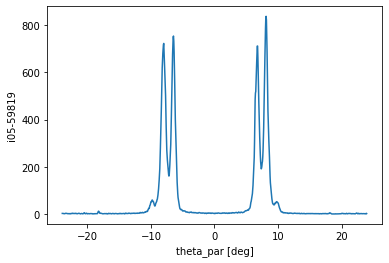

In [173]:
#MDC to subtract (bad example but shows the operation)
a.sel(eV=slice(105.04,105.06)).mean('eV').plot()

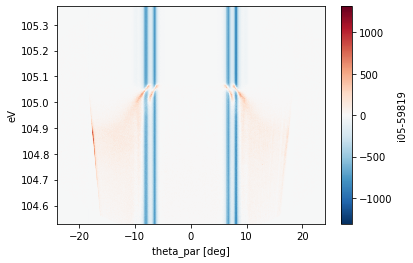

In [174]:
a.bgs(eV=slice(105.04,105.06)).plot(y='eV')

We have the full options from the normalisation methods, including feeding it a particular background wave as an xarray. E.g., let's use our linear background from before. 

 Analysis warning: Coordinates of normalisation wave do not match those in data. Interpolating for normalisation.


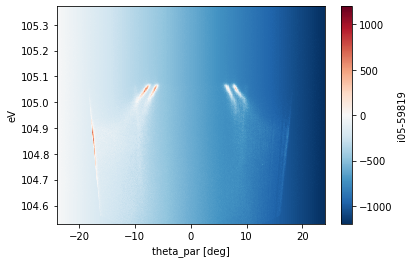

In [175]:
a.bgs(bgw).plot(y='eV')

There is also an option to subtract a Shirley background by calling with `Shirley`. The background is calculated over the full range passed. The options for averaging and left and right offsets can be passed as a dictionary of `Shirley_opts`. See `.fit.User_Fit_function.Shirley()` for more information on the background subtraction.

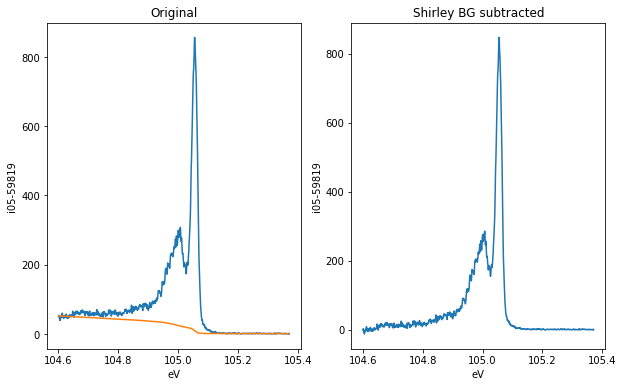

In [177]:
# Import the function now just so we can explicitly show the background here 
# (this is not required simply to do the BG subtraction)
from peaks.fit.User_Fit_function import Shirley
EDC1 = a.EDC(8, 0.5).sel(eV=slice(104.6,None))
Shirley_bg = Shirley(EDC1.data, average=3)

# This is how to do the simple Shirley BGS
EDC1_bgs = EDC1.bgs('Shirley', Shirley_opts={'average': 3})

# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10,6))
EDC1.plot(ax=ax[0])
ax[0].plot(EDC1.eV.data, Shirley_bg)
EDC1_bgs.plot(ax=ax[1])
ax[0].set_title('Original')
ax[1].set_title('Shirley BG subtracted')
plt.show()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='binning'></a>
## Data binning

### Binning using .coarsen
Binning can be performed using the built-in `xarray.coarsen` function. Use `keep_attrs=True` to retain the original attributes of the array.
### Example on a dispersion

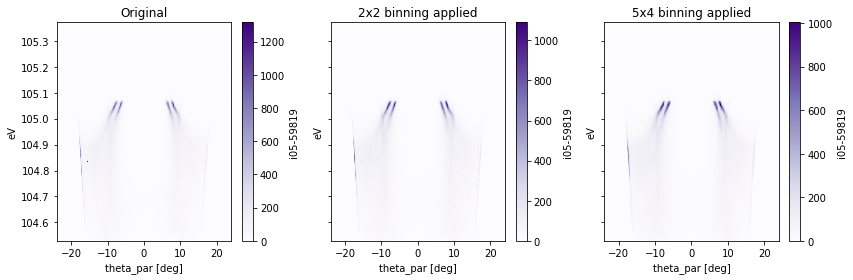

In [180]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV', ax=axes[0])
axes[0].set_title('Original')
#2x2 binning
b=a.coarsen(eV=2,theta_par=2).mean()
b.plot(y='eV', ax=axes[1])
axes[1].set_title('2x2 binning applied')
#5x4 binning
c=a.coarsen(eV=4,theta_par=5).mean()
c.plot(y='eV', ax=axes[2])
axes[2].set_title('5x4 binning applied')
plt.tight_layout()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='Smoothing'></a>
## Smoothing

Smoothing of data can be applied using `.process.smooth.smooth`:

In [181]:
help(smooth)

Help on function smooth in module peaks.process.smooth:

smooth(data, **kwargs)
    Smooth data contained in an xarray dataarray as per the specified parameters, and return the smoothed
    array. Uses scipy gaussian_filter function.
    
    Input:
        data - the data to smooth (xarray)
        **kwargs - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian
          for convolution in this direction (coord=ax)
    
    Returns:
        smoothed_data - the smoothed data (xarray)
        
    Example:
        smooth(dispersion, theta_par=0.5, eV=0.2) to smooth dispersion by a Gaussian with FWHM 0.5 deg and 0.2 eV



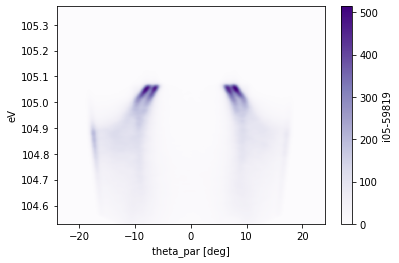

In [185]:
b = a.smooth(eV=0.01,theta_par=1)
b.plot(y='eV')

#### 3D example
Smoothing function can be applied to higher dimensional data, and will smooth (Gaussian convolution) over the axes specified. This now gets a bit slow for higher-D data...

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Smoothed also in energy direction')

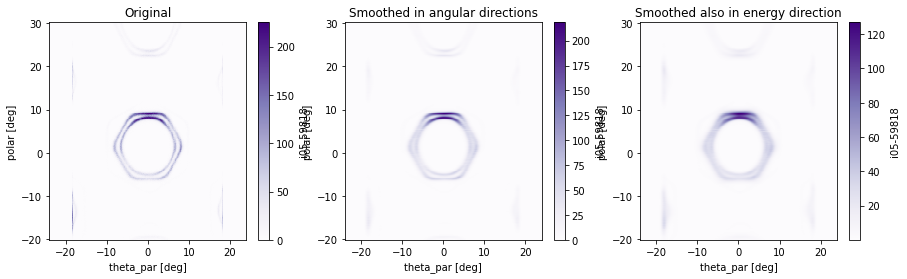

In [20]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')
fig, axes = plt.subplots(ncols=3,figsize=(15,4))
a.sel(eV=slice(105.04,105.06)).mean('eV').plot(ax=axes[0])
axes[0].set_title('Original')
a.smooth(polar=0.1,theta_par=1).pipe(FS,105.05,0.02).plot(ax=axes[1])
axes[1].set_title('Smoothed in angular directions')
a.smooth(polar=0.1,theta_par=1, eV=0.05).pipe(FS,105.05,0.02).plot(ax=axes[2])
axes[2].set_title('Smoothed also in energy direction')

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='deriv'></a>
## Derivative-type methods

`xarray` has an in-built derivative function, `.differentiate('dim')`:

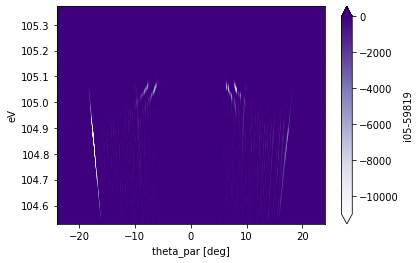

In [21]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
b = a.smooth(eV=0.02,theta_par=0.2).differentiate('theta_par').differentiate('theta_par')
b.plot(y='eV', vmin=0, vmax=-10000)

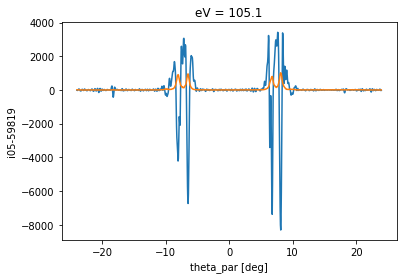

In [191]:
b.MDC(105.05).plot()
a.MDC(105.05).plot()

### Shortcut functions for taking useful derivatives for ARPES in `.process.deriv`
For second derivative of a dispersion in energy, call as `d2E(dispersion, <i>plot</i>, <i>kwargs</i>)` or `.pipe(d2E, dispersion, <i>plot</i>, <i>kwargs</i>)`:

In [192]:
help(d2E)

Help on function d2E in module peaks.process.deriv:

d2E(dispersion, plot=False, **kwargs)
    Perform double differential in the energy direction of data contained in an xarray dataarray, with
     smoothing applied as per the specified parameters.
    
    Input:
        dispersion - the data to differentiate (xarray)
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        diff_data - the smoothed and differentiated data (xarray)
        
    Example:
        d2E(dispersion, theta_par=0.5, eV=0.2) to smooth dispersion by a Gaussian with FWHM 0.5 deg and 0.2 eV and perform d2/d(E)^2



Equivalent versions exist for taking derivatives in the momentum (or angular) direction, `d2k(...)`, and for taking a combined derivative $d^2/dEdk$, `dEdk(...)`. The arguments are the same as above.

E.g. to take a second derivative in energy of an array with some smoothing in the two axes (FWHM 20 meV in eneergy, 0.2 deg in angle):

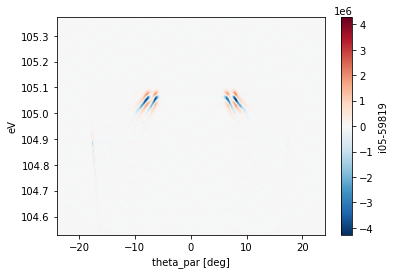

In [193]:
b = a.d2E(eV=0.02,theta_par=0.2)
b.plot(y='eV')

We can get this to return directly a plot with some attempt at a choice of sensible colour scale

In [194]:
a.d2E(eV=0.02,theta_par=0.2, plot=1)

You can also supply standard matplotlib calls to further spec the plot

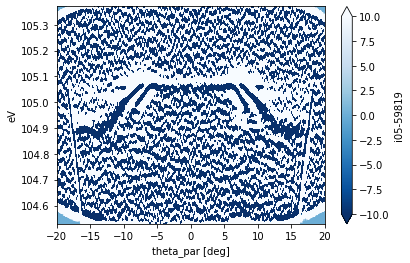

In [195]:
a.d2E(eV=0.02,theta_par=0.2, plot=1, xlim=[-20,20], vmin=-10, vmax=10, cmap='Blues_r')

Equivalent call for double derivative in the momentum direction. This in fact works on whatever is the non-energy direction of a 2D xarray, so can be used irrespective of e.g. `theta_par`, `k_par` etc. on angular axis:

In [196]:
a.d2k(eV=0.01,theta_par=0.5, plot=1, xlim=[-20,20])

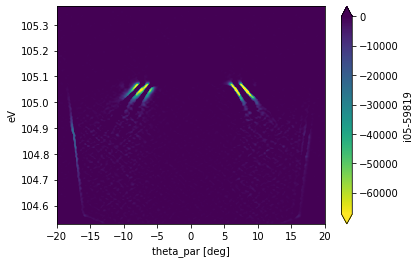

In [197]:
dEdk(a,eV=0.01,theta_par=0.5, plot=1, xlim=[-20,20])

### Second derivatives along any arbitrary axes in `.process.deriv`
Second derivatives can be taken along any combination of 2 axes. Call as `double_diff(data, dim1, dim2, <i>plot</i>, <i>kwargs</i>)` or `data.double_diff(coord1, coord2, <i>plot</i>, <i>kwargs</i>)` (this is in fact the master function for taking the derivatives called in all of the above shortcut versions):

In [198]:
help(double_diff)

Help on function double_diff in module peaks.process.deriv:

double_diff(data, dim1, dim2, plot=False, **kwargs)
    Perform double differential along the specified dimensions of data contained in an xarray dataarray
    
    Input:
        data - the data to differentiate (xarray)
        dim1 - dimension for first derivative
        dim2 - dimension for second derivative
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        diff_data - differentiated data (xarray)
        
    Example:
        double_diff(dispersion, 'eV', 'eV') to perform d2/d(eV)^2



E.g. to take a second derivative in energy:

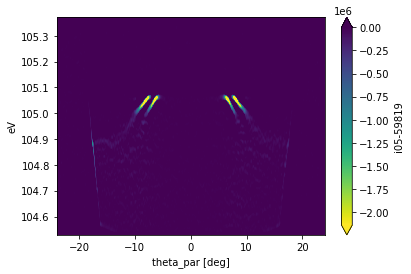

In [199]:
a.double_diff('eV','eV', eV=0.02,theta_par=0.2, plot=1)

<a id='curv'></a>
## Curvature analysis in `.process.deriv`
### 2D Curvature

In [200]:
help(curvature)

Help on function curvature in module peaks.process.deriv:

curvature(data, C0, C1, plot=False, **kwargs)
    Perform 2D curvature analysis (see Rev. Sci. Instrum.  82, 043712 (2011)) to data contained in an xarray
       dataarray
    
    Input:
        data - the data to differentiate (xarray)
        C0 - free parameter for axis 0
        C1 - free parameter for axis 1
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        curve_data - curvature data (xarray)
        
    Example:
        curvature(dispersion, 10, 1, plot=1, theta_par=0.3, eV=0.01) to perform curvature with some smoothing



C0 scaling for eV, C1 scaling for theta_par


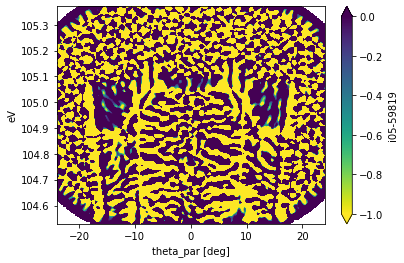

In [201]:
a.curvature(100,1000, plot=1, eV=0.02,theta_par=1,)

### 1D curvature

In [202]:
help(curv1d)

Help on function curv1d in module peaks.process.deriv:

curv1d(data, dim, C0, plot=False, **kwargs)
    Perform 1D curvature analysis (see Rev. Sci. Instrum.  82, 043712 (2011)) to data contained in an xarray
      dataarray
    
    Input:
        data - the data to differentiate (xarray)
        dim - name of the dimension to apply the curvature along
        C0 - free parameter
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        curve_data - curvature data (xarray)
        
    Example:
        curvature(dispersion, 10, 1, plot=1, theta_par=0.3, eV=0.01) to perform curvature with some smoothing



E.g. taking the 1d curvature along the 'eV' axis. If running with a very high C0 value, equilvaent to a standard second derivative plot. 

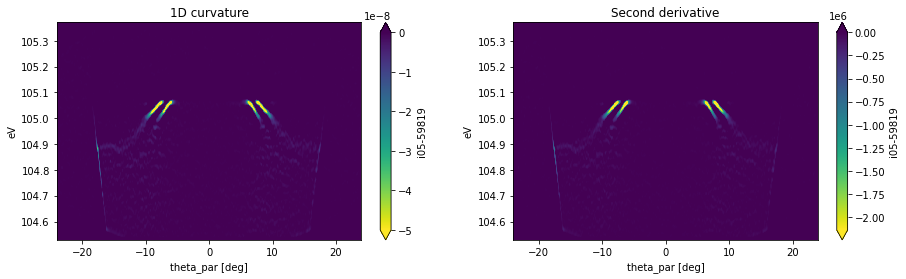

In [203]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 4))
#Curvature
a.curv1d('eV',1000000000, eV=0.02,theta_par=0.2, plot=1, vmin=-0.00000005, ax = axes[0])
axes[0].set_title('1D curvature');
#2nd derivative
a.d2E(eV=0.02,theta_par=0.2, plot=1, ax=axes[1])
axes[1].set_title('Second derivative');



But e.g. with a smaller C0:

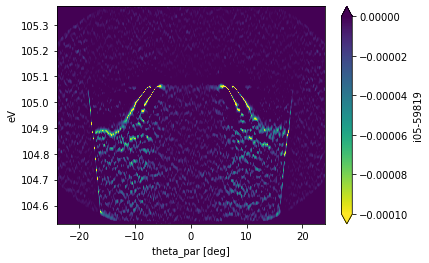

In [204]:
a.curv1d('eV',1000000, eV=0.02,theta_par=0.2, plot=1, vmin=-0.0001)

<a id='min_grad'></a>
## Minimum gradient method in `.process.deriv`
Applies minimum gradient analysis, using Gaussian filtering. Method based on Rev. Sci. Instrum 88 (2017) 073903, and uses the `scipy.ndimage.gaussian_gradient_magnitude` function. Call as `min_grad(a, <i>plot</i>, <i>kwargs</i>)` or `a.min_grad(<i>plot</i>, <i>kwargs</i>)`:

In [205]:
help(min_grad)

Help on function min_grad in module peaks.process.deriv:

min_grad(data, plot=False, **kwargs)
    Apply minimum gradient analysis, using Gaussian filtering. Method based on Rev. Sci. Instrum 88 (2017)
      073903, and uses the scipy.ndimage.gaussian_gradient_magnitude function.
    
    Input:
        data - the data to apply gradient magnetiude analysis to (xarray)
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        grad_mod - renormalised gradient modulus map (xarray)
        
    Example:
        min_grad(dispersion, theta_par=0.5, eV=0.2).



In [206]:
a.min_grad(plot=True, theta_par=0.5,eV=0.005)

 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide
 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide
 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


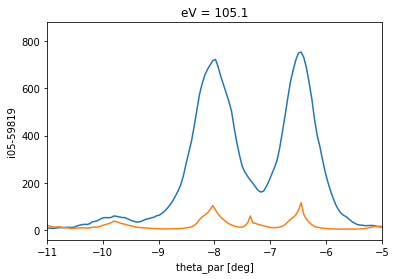

In [208]:
a.MDC(105.05, 0.02).plot(xlim=[-11,-5])
b = min_grad(a, plot=0, theta_par=0.5,eV=0.02)
b.MDC(105.05, 0.02).plot()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='symm'></a>
## Symmetrisation functions in `.process.symm`

### $E_f$ symmetrisation
`.process.symm.EF_sym` function to symmetrise an array in energy, useful e.g. for symmetrising about the Fermi level for gap analysis etc. 

Call as `EF_sym(a, En)` or `a.EF_sym(En)` where `a` is the relevant xarray dataarray to symmetrise and `En` is the energy to symmetrise about. `En` can be omitted, in which case set to default `En=0`:

In [209]:
help(EF_sym)

Help on function EF_sym in module peaks.process.symm:

EF_sym(dispersion, En=0.0)
    This function applies a symmetrisation around a given energy
    
    Input:
        dispersion - the dispersion to be symmetrised (xarray)
        En - float; energy for symmetrising about. Default is 0.0 eV (suitable for symmetrising around E_F if
          data is in binding energy)
    
    Returns:
        sym_dispersion - the symmetrised dispersion (xarray)



E.g., acting on single dispersion:

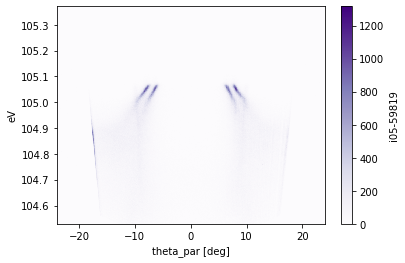

In [25]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

Symmetrise about the energy 105.06 eV

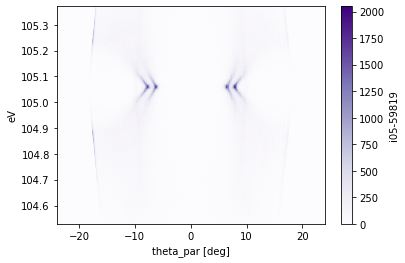

In [26]:
a.EF_sym(105.06).plot(y='eV')

Consider e.g. if we have already done E_F correction:

 Analysis warning: Fermi level set from automatic estimation to 105.068 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': -12.5}


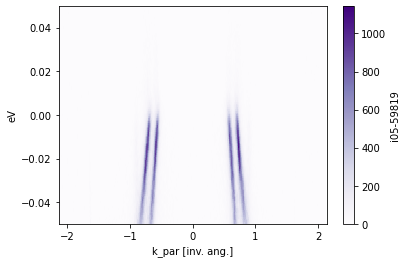

In [213]:
b = a.proc()
b.sel(eV=slice(-0.05,0.05)).plot(y='eV')

Now we can apply directly the E_F symmetrisation function to this without giving an energy arguemnt, in which case the Fermi energy is assumed for the symmetrisation:

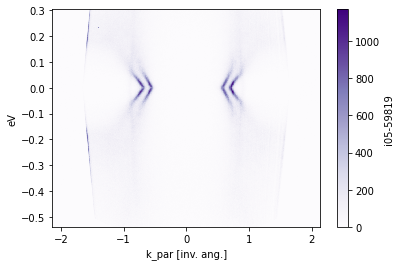

In [214]:
b.EF_sym().plot(y='eV')

#### Applying to higher-D arrays
This broadcasts across higher-dimensional arrays. E.g. for a Fermi surface map:

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

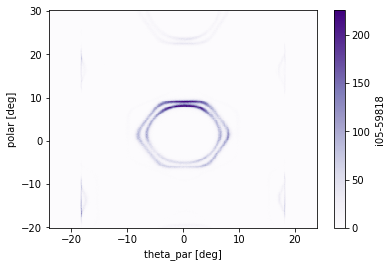

In [216]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')
a.sel(eV=slice(105.04,105.06)).mean('eV').plot()

Take a slice at 105.1 eV:

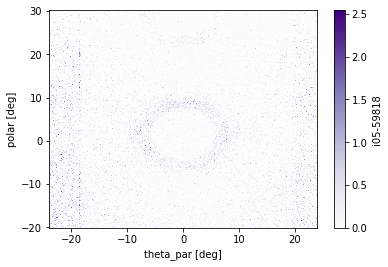

In [217]:
a.sel(eV=slice(105.1,105.11)).mean('eV').plot()

Symmetrise the data about the Fermi level (this takes a bit longer now)

In [220]:
b= a.EF_sym(105.067)

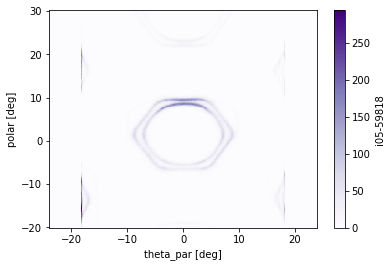

In [221]:
b.sel(eV=slice(105.1,105.11)).mean('eV').plot()

### `sym1d` function in `.process.symm`
Function to symmetrise an array around any 1D axis.

In [222]:
help(sym1d)

Help on function sym1d in module peaks.process.symm:

sym1d(dispersion, **kwargs)
    This function applies a symmetrisation around a given single axis
    
    Input:
        dispersion - the dispersion to be symmetrised (xarray)
        **kwarg optional arguments
            - ax = value, where ax is the name of the relevant xarray coordinate and value is the
              value for symmetrising about.
            - return_flipped = True, to return the flipped dispersion rather than the sum of the
              original and flipped
    
    Returns:
        sym_dispersion - the symmetrised dispersion (xarray)



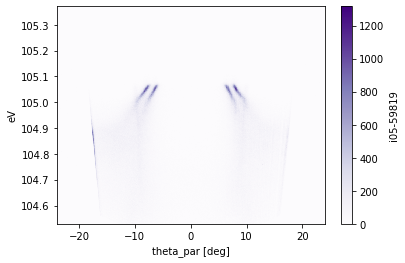

In [224]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

Example of symmetrising this array about theta_par = -6 as an illustrative example.

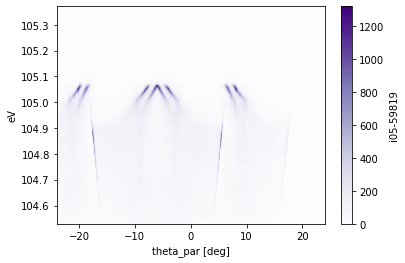

In [225]:
a.sym1d(theta_par=-6).plot(y='eV')

### `rotation` function in `.process.rotation`
Function to rotate an xarray

In [226]:
help(rotation)

Help on function rotation in module peaks.process.rotation:

rotation(xarray, rotation)
    This function takes a 2D input xarray and rotates it around (0,0)
    
    Inputs:
        xarray - the data which will be rotated (xarray)
        rotation - the rotation in degrees which will be applied (float/int)
    
    Returns:
        rotated_xarray - the rotated xarray



In [228]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

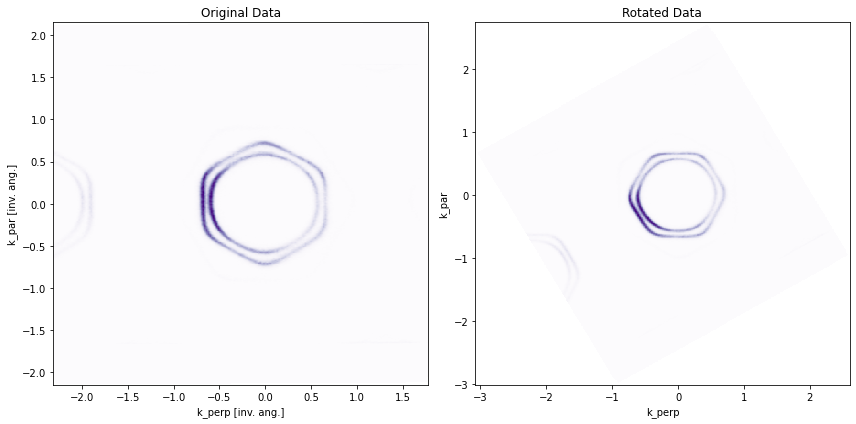

In [229]:
data = a.proc(FS=0.01, norm_polar = 1.4, norm_tilt = 0, norm_azi = a.attrs['azi'] + 0.3, EF_correction = 105.06)
rotated_data = data.rotation(30)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
data.plot(ax=axes[0],add_colorbar=False)
axes[0].set_title("Original Data")
rotated_data.plot(ax=axes[1],add_colorbar=False)
axes[1].set_title("Rotated Data")
plt.tight_layout()

### `rot_sym` function in `.process.symm`
Function to symmetrise an array by considering its rotation Symmetry

In [230]:
help(rot_sym)

Help on function rot_sym in module peaks.process.symm:

rot_sym(xarray, order, expand=True, fillna=True)
    This function takes a 2D input xarray and symmetrises it around a centre coordinate, by a goiven rotation order
    
    Inputs:
        xarray - the data which will be symmetrised (xarray)
        order - rotation order (int)
        **kwargs
            expand - whether or not to expand the coord grid
            fillna - whether or not to plot data where some rotated xarrays have nans
            
    Returns:
        symmetrised_xarray - the symmetrised xarray



 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


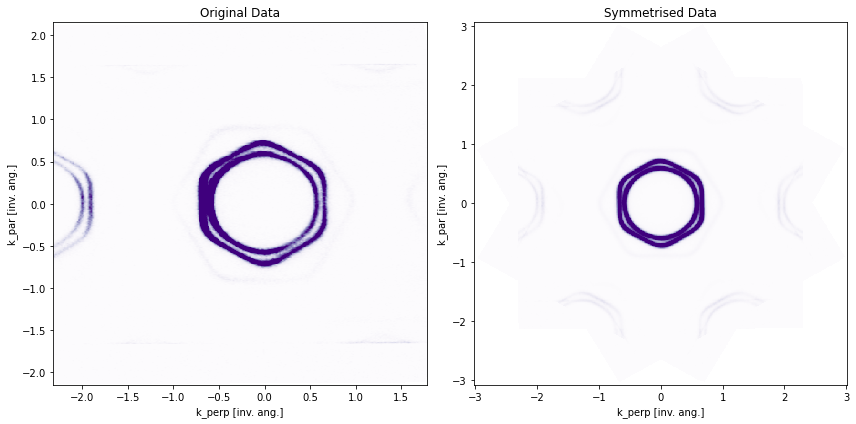

In [286]:
rot_sym_data = data.rot_sym(6)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
data.plot(ax=axes[0],add_colorbar=False,vmin=0,vmax=50)
axes[0].set_title("Original Data")
rot_sym_data.plot(ax=axes[1],add_colorbar=False,vmin=0,vmax=50)
axes[1].set_title("Symmetrised Data")
plt.tight_layout()

In [247]:
""" Methods for numba-accelerated bilinear and trilinear interpolation. """

import numpy as np
from numba import njit, prange


@njit(parallel=True)
def bilinear_interpolate_regular(
    desired_pos_dim0, desired_pos_dim1, orig_coords_dim0, orig_coords_dim1, orig_values
):

    # Flatten the desired positions
    desired_shape = desired_pos_dim0.shape  # Store for later
    desired_pos_dim0 = desired_pos_dim0.flatten()
    desired_pos_dim1 = desired_pos_dim1.flatten()

    n_points = desired_pos_dim0.size
    result = np.empty(n_points)

    for idx in prange(n_points):
        x = desired_pos_dim0[idx]
        y = desired_pos_dim1[idx]

        # Find the indices of the grid points surrounding (x, y)
        x1_idx = np.searchsorted(orig_coords_dim0, x) - 1
        x2_idx = x1_idx + 1
        y1_idx = np.searchsorted(orig_coords_dim1, y) - 1
        y2_idx = y1_idx + 1

        # Boundary check to ensure we do not go out of bounds
        if x1_idx < 0:
            x1_idx = 0
        if x2_idx >= len(orig_coords_dim0):
            x2_idx = len(orig_coords_dim0) - 1
        if y1_idx < 0:
            y1_idx = 0
        if y2_idx >= len(orig_coords_dim1):
            y2_idx = len(orig_coords_dim1) - 1

        # Coordinates for surrounding points
        x1 = orig_coords_dim0[x1_idx]
        x2 = orig_coords_dim0[x2_idx]
        y1 = orig_coords_dim1[y1_idx]
        y2 = orig_coords_dim1[y2_idx]

        # Values at surrounding points
        Q11 = orig_values[x1_idx, y1_idx]
        Q12 = orig_values[x1_idx, y2_idx]
        Q21 = orig_values[x2_idx, y1_idx]
        Q22 = orig_values[x2_idx, y2_idx]

        # Perform bilinear interpolation
        result[idx] = (
            Q11 * (x2 - x) * (y2 - y)
            + Q21 * (x - x1) * (y2 - y)
            + Q12 * (x2 - x) * (y - y1)
            + Q22 * (x - x1) * (y - y1)
        ) / ((x2 - x1) * (y2 - y1))

    return result.reshape(desired_shape)





In [249]:
# Example usage
var1 = np.array([[0.5, 1.5], [2.5, 3.5]])
var2 = np.array([[0.5, 1.5], [2.5, 3.5]])
x_coords = np.array([0, 1, 2, 3, 4])
y_coords = np.array([0, 1, 2, 3, 4])
values = np.array(
    [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16], [17, 18, 19, 20]]
)


In [251]:
%%time
result = bilinear_interpolate_regular(
    var1, var2, x_coords, y_coords, values
)

CPU times: user 177 μs, sys: 389 μs, total: 566 μs
Wall time: 133 μs
